## データの読込

In [1]:
import pandas as pd
df = pd.read_csv("vgsales-12-4-2019.csv")
df.head(3)

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,...,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,...,NaN,NaN,NaN,NaN,2006.0,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,...,NaN,NaN,NaN,NaN,1985.0,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,...,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg


### Stacking

In [2]:
import os
import time
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from natsort import natsorted 

import lightgbm as lgb
import optuna.integration.lightgbm as opt_lgb
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold

import warnings
warnings.simplefilter('ignore')

In [3]:
# シード値の固定
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    df.dropna(subset=["Global_Sales"]).drop(["Global_Sales",  "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"], axis=1), 
                                                    df.dropna(subset=["Global_Sales"])["Global_Sales"],  
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    random_state=SEED
                                                    ) 

In [5]:
### 欠損値補完
X_train_ff = X_train.fillna(method='ffill')
X_test_ff = X_test.fillna(method='ffill')

#### カテゴリーエンコーディング

# ユニーク数に応じてカラムを分割する
category_unique_num = X_train_ff.select_dtypes(include="object").nunique()

few_kinds_category_columns = category_unique_num[category_unique_num < 10].index
many_kinds_category_columns = category_unique_num[category_unique_num >= 10].index


# カテゴリーのエンコーディング法則を指定する
ordinal_all_cols_mapping_ce = []

for i, column in enumerate(many_kinds_category_columns):
    ordinal_one_cols_mapping = {}
    ordinal_one_cols_mapping_breakdown = {}
    for j, category in enumerate(natsorted(X_train_ff[column].unique())):
        ordinal_one_cols_mapping_breakdown[category] = j

    ordinal_one_cols_mapping["col"] = column
    ordinal_one_cols_mapping["mapping"] = ordinal_one_cols_mapping_breakdown
    ordinal_all_cols_mapping_ce.append(ordinal_one_cols_mapping)


# エンコーディング設定
ode = ce.OrdinalEncoder(
    mapping = ordinal_all_cols_mapping_ce,
    cols = many_kinds_category_columns
)

ohe = ce.OneHotEncoder(
    use_cat_names=True,
    cols = few_kinds_category_columns
)

# 元データをコピー
X_train_ce = X_train_ff.copy()
X_test_ce = X_test_ff.copy()

# OneHotEncoder
X_train_ce = ohe.fit_transform(X_train_ce)
X_test_ce = ohe.transform(X_test_ce)

# OrdinalHotEncoder
X_train_ce = ode.fit_transform(X_train_ce)
X_test_ce = ode.transform(X_test_ce)

# 正規化
sc = StandardScaler()
X_train_ce = pd.DataFrame(
                            sc.fit_transform(X_train_ce),
                            columns=X_train_ce.columns
                            )

X_test_ce = pd.DataFrame(
                            sc.transform(X_test_ce),
                            columns=X_test_ce.columns
                            )

In [6]:
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# 欠損の削除
X_train_dropna = X_train_ce.dropna(how="all", axis=1)
X_train_dropna = X_train_dropna.dropna(how="any", axis=0)

X_test_dropna = X_test_ce.dropna(how="all", axis=1)
X_test_dropna = X_test_dropna.dropna(how="any", axis=0)


# X の欠損行を削除したので、y もそれに合わせる
y_train = y_train.reset_index(drop=True)
y_train_dropna = y_train[y_train.index.isin(X_train_dropna.index)]

y_test = y_test.reset_index(drop=True)
y_test_dropna = y_test[y_test.index.isin(X_test_dropna.index)]

[I 2021-12-27 16:44:01,604] A new study created in memory with name: no-name-8877c4c1-b63b-426c-86db-c9805966be0a


[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:44:02,429] Trial 0 finished with value: 0.33794585175354636 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.33794585175354636.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.124582	Test's rmse: 0.337946
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:44:03,266] Trial 1 finished with value: 0.35770412039361804 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.33794585175354636.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.12444	Test's rmse: 0.357704
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:44:04,159] Trial 2 finished with value: 0.3644971750143779 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.33794585175354636.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.116941	Test's rmse: 0.364497
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:44:04,941] Trial 3 finished with value: 0.349062544374099 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.33794585175354636.


Early stopping, best iteration is:
[40]	Train's rmse: 0.150359	Test's rmse: 0.349063
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:44:05,839] Trial 4 finished with value: 0.35795276425009165 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.33794585175354636.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.110067	Test's rmse: 0.357953
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:44:06,658] Trial 5 finished with value: 0.34957507200767585 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.33794585175354636.


Early stopping, best iteration is:
[43]	Train's rmse: 0.151631	Test's rmse: 0.349575
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:44:07,366] Trial 6 finished with value: 0.3454863714709596 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.33794585175354636.


Early stopping, best iteration is:
[34]	Train's rmse: 0.153648	Test's rmse: 0.345486
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:44:11,352] Trial 7 finished with value: 0.33788818244150526 and parameters: {'num_leaves': 205}. Best is trial 7 with value: 0.33788818244150526.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.118662	Test's rmse: 0.337888
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:44:14,369] Trial 8 finished with value: 0.3390263121512149 and parameters: {'num_leaves': 228}. Best is trial 7 with value: 0.33788818244150526.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.124594	Test's rmse: 0.339026
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:44:14,570] Trial 9 finished with value: 0.33928733084051543 and parameters: {'num_leaves': 9}. Best is trial 7 with value: 0.33788818244150526.


Early stopping, best iteration is:
[40]	Train's rmse: 0.147423	Test's rmse: 0.339287
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:44:16,681] Trial 10 finished with value: 0.33724401563817574 and parameters: {'num_leaves': 170}. Best is trial 10 with value: 0.33724401563817574.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.11989	Test's rmse: 0.337244
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 16:44:21,029] Trial 11 finished with value: 0.3372404036070058 and parameters: {'num_leaves': 253}. Best is trial 11 with value: 0.3372404036070058.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.120026	Test's rmse: 0.33724
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:44:25,193] Trial 12 finished with value: 0.33654820832650584 and parameters: {'num_leaves': 121}. Best is trial 12 with value: 0.33654820832650584.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119895	Test's rmse: 0.336548
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:44:32,068] Trial 13 finished with value: 0.3393739345185663 and parameters: {'num_leaves': 231}. Best is trial 12 with value: 0.33654820832650584.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.12328	Test's rmse: 0.339374
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:44:35,326] Trial 14 finished with value: 0.3419444873832503 and parameters: {'num_leaves': 91}. Best is trial 12 with value: 0.33654820832650584.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.121982	Test's rmse: 0.341944
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:44:39,012] Trial 15 finished with value: 0.3379916792589188 and parameters: {'num_leaves': 95}. Best is trial 12 with value: 0.33654820832650584.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.123299	Test's rmse: 0.337992
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:44:41,640] Trial 16 finished with value: 0.3382301871632053 and parameters: {'num_leaves': 77}. Best is trial 12 with value: 0.33654820832650584.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.120313	Test's rmse: 0.33823
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:44:45,843] Trial 17 finished with value: 0.3392574544644687 and parameters: {'num_leaves': 150}. Best is trial 12 with value: 0.33654820832650584.


Early stopping, best iteration is:
[39]	Train's rmse: 0.146782	Test's rmse: 0.339257
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 16:44:51,857] Trial 18 finished with value: 0.33710016396461406 and parameters: {'num_leaves': 255}. Best is trial 12 with value: 0.33654820832650584.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.12006	Test's rmse: 0.3371
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:44:56,096] Trial 19 finished with value: 0.338067036723505 and parameters: {'num_leaves': 182}. Best is trial 12 with value: 0.33654820832650584.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119969	Test's rmse: 0.338067
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:44:59,233] Trial 20 finished with value: 0.3379609187261017 and parameters: {'num_leaves': 127}. Best is trial 12 with value: 0.33654820832650584.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119394	Test's rmse: 0.337961
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:45:00,278] Trial 21 finished with value: 0.34384114637363705 and parameters: {'num_leaves': 44}. Best is trial 12 with value: 0.33654820832650584.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.125633	Test's rmse: 0.343841
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:45:03,107] Trial 22 finished with value: 0.3376658227119716 and parameters: {'num_leaves': 123}. Best is trial 12 with value: 0.33654820832650584.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.120122	Test's rmse: 0.337666
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:45:06,027] Trial 23 finished with value: 0.33924223879097365 and parameters: {'num_leaves': 153}. Best is trial 12 with value: 0.33654820832650584.


Early stopping, best iteration is:
[39]	Train's rmse: 0.146771	Test's rmse: 0.339242
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:45:07,530] Trial 24 finished with value: 0.34060065843471765 and parameters: {'num_leaves': 50}. Best is trial 12 with value: 0.33654820832650584.


Early stopping, best iteration is:
[47]	Train's rmse: 0.143721	Test's rmse: 0.340601
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:45:12,704] Trial 25 finished with value: 0.33723804911433936 and parameters: {'num_leaves': 194}. Best is trial 12 with value: 0.33654820832650584.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119886	Test's rmse: 0.337238
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:45:15,461] Trial 26 finished with value: 0.33654820832650584 and parameters: {'num_leaves': 121}. Best is trial 12 with value: 0.33654820832650584.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119895	Test's rmse: 0.336548
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:45:18,092] Trial 27 finished with value: 0.31408028532682497 and parameters: {'bagging_fraction': 0.7171922876090577, 'bagging_freq': 6}. Best is trial 27 with value: 0.31408028532682497.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.152502	Test's rmse: 0.31408
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:45:21,797] Trial 28 finished with value: 0.33100819619908173 and parameters: {'bagging_fraction': 0.6200574173415849, 'bagging_freq': 1}. Best is trial 27 with value: 0.31408028532682497.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.156478	Test's rmse: 0.331008
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:45:25,259] Trial 29 finished with value: 0.3155379577322029 and parameters: {'bagging_fraction': 0.8253405836626732, 'bagging_freq': 5}. Best is trial 27 with value: 0.31408028532682497.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147316	Test's rmse: 0.315538
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:45:28,974] Trial 30 finished with value: 0.32667888336418616 and parameters: {'bagging_fraction': 0.48417843165329844, 'bagging_freq': 4}. Best is trial 27 with value: 0.31408028532682497.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.165931	Test's rmse: 0.326679
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:45:32,000] Trial 31 finished with value: 0.3225488923786112 and parameters: {'bagging_fraction': 0.830684208691374, 'bagging_freq': 6}. Best is trial 27 with value: 0.31408028532682497.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15189	Test's rmse: 0.322549
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:45:34,013] Trial 32 finished with value: 0.3256886868604525 and parameters: {'bagging_fraction': 0.8436334148806368, 'bagging_freq': 4}. Best is trial 27 with value: 0.31408028532682497.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136186	Test's rmse: 0.325689
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:45:36,103] Trial 33 finished with value: 0.324935526958964 and parameters: {'bagging_fraction': 0.8622301009578774, 'bagging_freq': 2}. Best is trial 27 with value: 0.31408028532682497.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137961	Test's rmse: 0.324936
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:45:38,370] Trial 34 finished with value: 0.32420378146791357 and parameters: {'bagging_fraction': 0.6916159639775898, 'bagging_freq': 2}. Best is trial 27 with value: 0.31408028532682497.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.161302	Test's rmse: 0.324204
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:45:40,634] Trial 35 finished with value: 0.3219783774933769 and parameters: {'bagging_fraction': 0.6900569700388897, 'bagging_freq': 5}. Best is trial 27 with value: 0.31408028532682497.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.153073	Test's rmse: 0.321978
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:45:42,340] Trial 36 finished with value: 0.3283039579707948 and parameters: {'bagging_fraction': 0.6030183524297181, 'bagging_freq': 7}. Best is trial 27 with value: 0.31408028532682497.


Did not meet early stopping. Best iteration is:
[91]	Train's rmse: 0.155741	Test's rmse: 0.328304
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:45:45,212] Trial 37 finished with value: 0.3103381739553991 and parameters: {'feature_fraction': 0.9799999999999999}. Best is trial 37 with value: 0.3103381739553991.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.155549	Test's rmse: 0.310338
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:45:47,538] Trial 38 finished with value: 0.33002103467938987 and parameters: {'feature_fraction': 0.82}. Best is trial 37 with value: 0.3103381739553991.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144445	Test's rmse: 0.330021
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:45:51,175] Trial 39 finished with value: 0.3253540470325624 and parameters: {'feature_fraction': 0.852}. Best is trial 37 with value: 0.3103381739553991.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144755	Test's rmse: 0.325354
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:45:55,829] Trial 40 finished with value: 0.31389339687423873 and parameters: {'feature_fraction': 0.948}. Best is trial 37 with value: 0.3103381739553991.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154072	Test's rmse: 0.313893
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:45:58,784] Trial 41 finished with value: 0.31408028532682497 and parameters: {'feature_fraction': 0.9159999999999999}. Best is trial 37 with value: 0.3103381739553991.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.152502	Test's rmse: 0.31408
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:46:01,771] Trial 42 finished with value: 0.31408028532682497 and parameters: {'feature_fraction': 0.8839999999999999}. Best is trial 37 with value: 0.3103381739553991.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.152502	Test's rmse: 0.31408
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:46:04,487] Trial 43 finished with value: 0.3095857017989739 and parameters: {'lambda_l1': 8.222702020447652e-08, 'lambda_l2': 0.0004162599847732468}. Best is trial 43 with value: 0.3095857017989739.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.157137	Test's rmse: 0.309586
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 16:46:06,305] Trial 44 finished with value: 0.310170401611515 and parameters: {'lambda_l1': 1.2147651511189295e-06, 'lambda_l2': 0.005668108258593364}. Best is trial 43 with value: 0.3095857017989739.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.156991	Test's rmse: 0.31017
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2021-12-27 16:46:06,655] Trial 45 finished with value: 0.325413834927835 and parameters: {'lambda_l1': 5.739815328261596, 'lambda_l2': 5.690744453161589e-06}. Best is trial 43 with value: 0.3095857017989739.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.149344	Test's rmse: 0.325414
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve

[I 2021-12-27 16:46:08,873] Trial 46 finished with value: 0.31004904111840986 and parameters: {'lambda_l1': 0.0003672561974183511, 'lambda_l2': 1.3008410947732453e-06}. Best is trial 43 with value: 0.3095857017989739.


Did not meet early stopping. Best iteration is:
[90]	Train's rmse: 0.158281	Test's rmse: 0.310049
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:46:11,307] Trial 47 finished with value: 0.3104036824607481 and parameters: {'lambda_l1': 1.468519852164094e-08, 'lambda_l2': 0.0008542674298233033}. Best is trial 43 with value: 0.3095857017989739.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.155547	Test's rmse: 0.310404
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2021-12-27 16:46:13,603] Trial 48 finished with value: 0.3097955181718409 and parameters: {'lambda_l1': 1.791611625120194e-07, 'lambda_l2': 1.1073440610900391}. Best is trial 43 with value: 0.3095857017989739.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.158298	Test's rmse: 0.309796
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2021-12-27 16:46:16,143] Trial 49 finished with value: 0.3102804013341091 and parameters: {'lambda_l1': 3.7769973358918555e-05, 'lambda_l2': 0.03171231942315755}. Best is trial 43 with value: 0.3095857017989739.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.156017	Test's rmse: 0.31028
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:46:18,576] Trial 50 finished with value: 0.3103381740380207 and parameters: {'lambda_l1': 1.2573779149971507e-08, 'lambda_l2': 2.0981166822140907e-08}. Best is trial 43 with value: 0.3095857017989739.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.155549	Test's rmse: 0.310338
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2021-12-27 16:46:20,899] Trial 51 finished with value: 0.3120237593847836 and parameters: {'lambda_l1': 1.0826953087723055e-08, 'lambda_l2': 0.26340595699955355}. Best is trial 43 with value: 0.3095857017989739.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.155929	Test's rmse: 0.312024
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2021-12-27 16:46:21,663] Trial 52 finished with value: 0.32510203879641125 and parameters: {'lambda_l1': 1.0266720399718836, 'lambda_l2': 9.299935420109215e-06}. Best is trial 43 with value: 0.3095857017989739.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.156387	Test's rmse: 0.325102
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2021-12-27 16:46:23,699] Trial 53 finished with value: 0.30963352061816657 and parameters: {'lambda_l1': 0.009403214549837816, 'lambda_l2': 0.00034009978332623174}. Best is trial 43 with value: 0.3095857017989739.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.156528	Test's rmse: 0.309634
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2021-12-27 16:46:25,482] Trial 54 finished with value: 0.3088855098330511 and parameters: {'lambda_l1': 0.02942830084401025, 'lambda_l2': 0.0001477620014738999}. Best is trial 54 with value: 0.3088855098330511.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15565	Test's rmse: 0.308886
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2021-12-27 16:46:27,256] Trial 55 finished with value: 0.31057548334413354 and parameters: {'lambda_l1': 0.02979420817420242, 'lambda_l2': 2.8410073832434074e-05}. Best is trial 54 with value: 0.3088855098330511.


Did not meet early stopping. Best iteration is:
[90]	Train's rmse: 0.15829	Test's rmse: 0.310575
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2021-12-27 16:46:29,198] Trial 56 finished with value: 0.31965093957636753 and parameters: {'lambda_l1': 7.287531926137672e-05, 'lambda_l2': 9.099814492347702}. Best is trial 54 with value: 0.3088855098330511.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.159451	Test's rmse: 0.319651
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2021-12-27 16:46:32,287] Trial 57 finished with value: 0.30889833236122566 and parameters: {'lambda_l1': 0.004127871725683431, 'lambda_l2': 0.00011932944300361442}. Best is trial 54 with value: 0.3088855098330511.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.156893	Test's rmse: 0.308898
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2021-12-27 16:46:35,505] Trial 58 finished with value: 0.3102049330089346 and parameters: {'lambda_l1': 0.035818017615528976, 'lambda_l2': 1.5086962309004422e-07}. Best is trial 54 with value: 0.3088855098330511.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.156695	Test's rmse: 0.310205
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2021-12-27 16:46:39,162] Trial 59 finished with value: 0.30885676178040017 and parameters: {'lambda_l1': 0.0065632667784234515, 'lambda_l2': 5.47131773995572e-05}. Best is trial 59 with value: 0.30885676178040017.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.156766	Test's rmse: 0.308857
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2021-12-27 16:46:40,502] Trial 60 finished with value: 0.3114619184868239 and parameters: {'lambda_l1': 0.33479644109208656, 'lambda_l2': 0.005313760216725511}. Best is trial 59 with value: 0.30885676178040017.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 16:46:42,765] Trial 61 finished with value: 0.30989044785169517 and parameters: {'lambda_l1': 0.00136655238139293, 'lambda_l2': 3.297660647470371e-07}. Best is trial 59 with value: 0.30885676178040017.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.155687	Test's rmse: 0.30989
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2021-12-27 16:46:43,669] Trial 62 finished with value: 0.31226729307834644 and parameters: {'lambda_l1': 0.27650725573252616, 'lambda_l2': 4.536798111854546e-05}. Best is trial 59 with value: 0.30885676178040017.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 16:46:45,632] Trial 63 finished with value: 0.31491623091149706 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.31491623091149706.


Early stopping, best iteration is:
[48]	Train's rmse: 0.0676158	Test's rmse: 0.314916
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2021-12-27 16:46:47,482] Trial 64 finished with value: 0.3180103644943588 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 0.31491623091149706.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0879618	Test's rmse: 0.31801
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2021-12-27 16:46:48,928] Trial 65 finished with value: 0.31870624931638164 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.31491623091149706.


Did not meet early stopping. Best iteration is:
[90]	Train's rmse: 0.16061	Test's rmse: 0.318706
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2021-12-27 16:46:50,093] Trial 66 finished with value: 0.3744701794533072 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.31491623091149706.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.226758	Test's rmse: 0.37447
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 20
[LightGBM] [Info] Start training from score 0.358120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, be

[I 2021-12-27 16:46:50,968] Trial 67 finished with value: 0.42127834130184505 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.31491623091149706.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.270662	Test's rmse: 0.421278


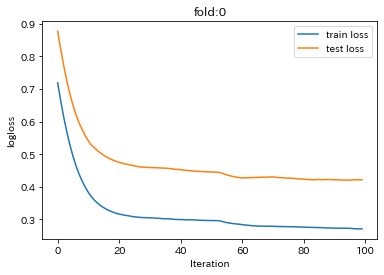

[I 2021-12-27 16:46:51,356] A new study created in memory with name: no-name-fa327601-d937-4013-8d61-e08818bda32a


[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:46:51,966] Trial 0 finished with value: 0.11004246511107606 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.11004246511107606.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134532	Test's rmse: 0.110042
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:46:52,553] Trial 1 finished with value: 0.14204225822785094 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.11004246511107606.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137597	Test's rmse: 0.142042
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:46:53,100] Trial 2 finished with value: 0.1125629552790824 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.11004246511107606.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15304	Test's rmse: 0.112563
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:46:53,624] Trial 3 finished with value: 0.11739376210387678 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.11004246511107606.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148377	Test's rmse: 0.117394
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:46:54,228] Trial 4 finished with value: 0.1378812376007257 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.11004246511107606.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137518	Test's rmse: 0.137881
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:46:54,791] Trial 5 finished with value: 0.11363014284870279 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.11004246511107606.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127015	Test's rmse: 0.11363
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:46:55,607] Trial 6 finished with value: 0.12132702105097964 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.11004246511107606.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128122	Test's rmse: 0.121327
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:46:59,021] Trial 7 finished with value: 0.11859404732880714 and parameters: {'num_leaves': 231}. Best is trial 7 with value: 0.11859404732880714.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141581	Test's rmse: 0.118594
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:00,232] Trial 8 finished with value: 0.10862423488603458 and parameters: {'num_leaves': 86}. Best is trial 8 with value: 0.10862423488603458.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132541	Test's rmse: 0.108624
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:02,299] Trial 9 finished with value: 0.11454704398436333 and parameters: {'num_leaves': 227}. Best is trial 8 with value: 0.10862423488603458.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134253	Test's rmse: 0.114547
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:02,910] Trial 10 finished with value: 0.10794402989432626 and parameters: {'num_leaves': 50}. Best is trial 10 with value: 0.10794402989432626.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133602	Test's rmse: 0.107944
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:05,335] Trial 11 finished with value: 0.11462956905445174 and parameters: {'num_leaves': 221}. Best is trial 10 with value: 0.10794402989432626.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134448	Test's rmse: 0.11463
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:07,645] Trial 12 finished with value: 0.11389094488593779 and parameters: {'num_leaves': 204}. Best is trial 10 with value: 0.10794402989432626.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133144	Test's rmse: 0.113891
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:08,278] Trial 13 finished with value: 0.10550043830950709 and parameters: {'num_leaves': 41}. Best is trial 13 with value: 0.10550043830950709.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134335	Test's rmse: 0.1055
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:09,597] Trial 14 finished with value: 0.11249459367076756 and parameters: {'num_leaves': 91}. Best is trial 13 with value: 0.10550043830950709.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132552	Test's rmse: 0.112495
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:11,748] Trial 15 finished with value: 0.11436422946149234 and parameters: {'num_leaves': 133}. Best is trial 13 with value: 0.10550043830950709.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133821	Test's rmse: 0.114364
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:12,088] Trial 16 finished with value: 0.10258630774247708 and parameters: {'num_leaves': 12}. Best is trial 16 with value: 0.10258630774247708.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135597	Test's rmse: 0.102586
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:12,301] Trial 17 finished with value: 0.11702014229808344 and parameters: {'num_leaves': 4}. Best is trial 16 with value: 0.10258630774247708.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.177546	Test's rmse: 0.11702
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.177546	Test's rmse: 0.11702


[I 2021-12-27 16:47:12,510] Trial 18 finished with value: 0.11702014229808344 and parameters: {'num_leaves': 4}. Best is trial 16 with value: 0.10258630774247708.


[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:13,606] Trial 19 finished with value: 0.10718254134179928 and parameters: {'num_leaves': 48}. Best is trial 16 with value: 0.10258630774247708.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135502	Test's rmse: 0.107183
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:16,427] Trial 20 finished with value: 0.11381291283007744 and parameters: {'num_leaves': 163}. Best is trial 16 with value: 0.10258630774247708.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136944	Test's rmse: 0.113813
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:17,353] Trial 21 finished with value: 0.10485179858374839 and parameters: {'num_leaves': 36}. Best is trial 16 with value: 0.10258630774247708.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134899	Test's rmse: 0.104852
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:18,923] Trial 22 finished with value: 0.10952882841323477 and parameters: {'num_leaves': 84}. Best is trial 16 with value: 0.10258630774247708.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.1366	Test's rmse: 0.109529
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:19,500] Trial 23 finished with value: 0.10620640789127936 and parameters: {'num_leaves': 26}. Best is trial 16 with value: 0.10258630774247708.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134672	Test's rmse: 0.106206
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:21,639] Trial 24 finished with value: 0.11062978492808342 and parameters: {'num_leaves': 114}. Best is trial 16 with value: 0.10258630774247708.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135069	Test's rmse: 0.11063
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:22,865] Trial 25 finished with value: 0.10810780791509261 and parameters: {'num_leaves': 60}. Best is trial 16 with value: 0.10258630774247708.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134503	Test's rmse: 0.108108
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:25,510] Trial 26 finished with value: 0.1139593356302467 and parameters: {'num_leaves': 156}. Best is trial 16 with value: 0.10258630774247708.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137336	Test's rmse: 0.113959
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:25,945] Trial 27 finished with value: 0.11435525158999901 and parameters: {'bagging_fraction': 0.9180407437516661, 'bagging_freq': 3}. Best is trial 27 with value: 0.11435525158999901.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148368	Test's rmse: 0.114355
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:26,304] Trial 28 finished with value: 0.11431899164824826 and parameters: {'bagging_fraction': 0.8170427711093223, 'bagging_freq': 7}. Best is trial 28 with value: 0.11431899164824826.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.17024	Test's rmse: 0.114319
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:26,691] Trial 29 finished with value: 0.11371797395463554 and parameters: {'bagging_fraction': 0.962468444379443, 'bagging_freq': 4}. Best is trial 29 with value: 0.11371797395463554.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14132	Test's rmse: 0.113718
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:27,049] Trial 30 finished with value: 0.10635611938628602 and parameters: {'bagging_fraction': 0.6354545878268228, 'bagging_freq': 4}. Best is trial 30 with value: 0.10635611938628602.


Early stopping, best iteration is:
[45]	Train's rmse: 0.200498	Test's rmse: 0.106356
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:27,475] Trial 31 finished with value: 0.1193246427681918 and parameters: {'bagging_fraction': 0.6908288764708954, 'bagging_freq': 1}. Best is trial 30 with value: 0.10635611938628602.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.171602	Test's rmse: 0.119325
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:27,828] Trial 32 finished with value: 0.10881198906462677 and parameters: {'bagging_fraction': 0.8692199621327877, 'bagging_freq': 6}. Best is trial 30 with value: 0.10635611938628602.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.156935	Test's rmse: 0.108812
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:28,173] Trial 33 finished with value: 0.1132026318085252 and parameters: {'bagging_fraction': 0.8141240302593145, 'bagging_freq': 1}. Best is trial 30 with value: 0.10635611938628602.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.158585	Test's rmse: 0.113203
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:28,520] Trial 34 finished with value: 0.12319673192237202 and parameters: {'bagging_fraction': 0.5545993849335606, 'bagging_freq': 6}. Best is trial 30 with value: 0.10635611938628602.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.187694	Test's rmse: 0.123197
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:28,864] Trial 35 finished with value: 0.11471620612049381 and parameters: {'bagging_fraction': 0.668052153656004, 'bagging_freq': 2}. Best is trial 30 with value: 0.10635611938628602.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.175143	Test's rmse: 0.114716
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:29,161] Trial 36 finished with value: 0.10141462444901116 and parameters: {'bagging_fraction': 0.8825756094248127, 'bagging_freq': 4}. Best is trial 36 with value: 0.10141462444901116.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.153041	Test's rmse: 0.101415
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:29,468] Trial 37 finished with value: 0.11090204760126815 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 37 with value: 0.11090204760126815.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.151242	Test's rmse: 0.110902
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:29,841] Trial 38 finished with value: 0.10141462444901116 and parameters: {'feature_fraction': 0.784}. Best is trial 38 with value: 0.10141462444901116.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.153041	Test's rmse: 0.101415
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:30,161] Trial 39 finished with value: 0.11086230247315124 and parameters: {'feature_fraction': 0.88}. Best is trial 38 with value: 0.10141462444901116.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168491	Test's rmse: 0.110862
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:30,497] Trial 40 finished with value: 0.10141462444901116 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 38 with value: 0.10141462444901116.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.153041	Test's rmse: 0.101415
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:30,783] Trial 41 finished with value: 0.10333395514401547 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 38 with value: 0.10141462444901116.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148387	Test's rmse: 0.103334
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:31,053] Trial 42 finished with value: 0.10384719969288422 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 38 with value: 0.10141462444901116.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154549	Test's rmse: 0.103847
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:31,357] Trial 43 finished with value: 0.10141462472850446 and parameters: {'lambda_l1': 1.2801895955785344e-06, 'lambda_l2': 1.937598494774381e-07}. Best is trial 43 with value: 0.10141462472850446.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.153041	Test's rmse: 0.101415
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:31,676] Trial 44 finished with value: 0.10141471893200299 and parameters: {'lambda_l1': 0.00029758469536382104, 'lambda_l2': 6.677628800803741e-06}. Best is trial 43 with value: 0.10141462472850446.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.153042	Test's rmse: 0.101415
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:31,954] Trial 45 finished with value: 0.10928413457815557 and parameters: {'lambda_l1': 1.4032598227632929, 'lambda_l2': 2.0504990319545144}. Best is trial 43 with value: 0.10141462472850446.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.146953	Test's rmse: 0.109284
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:32,239] Trial 46 finished with value: 0.09985059764205909 and parameters: {'lambda_l1': 0.0006498303739331013, 'lambda_l2': 0.0633653630563315}. Best is trial 46 with value: 0.09985059764205909.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.155594	Test's rmse: 0.0998506
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:32,563] Trial 47 finished with value: 0.10141462457198551 and parameters: {'lambda_l1': 1.7853951234473453e-07, 'lambda_l2': 1.8177569449036773e-08}. Best is trial 46 with value: 0.09985059764205909.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.153041	Test's rmse: 0.101415
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:32,862] Trial 48 finished with value: 0.10141463831032042 and parameters: {'lambda_l1': 4.444023126944863e-05, 'lambda_l2': 1.4215651997812042e-07}. Best is trial 46 with value: 0.09985059764205909.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.153041	Test's rmse: 0.101415
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:33,168] Trial 49 finished with value: 0.10148450414545312 and parameters: {'lambda_l1': 0.0008650580971975618, 'lambda_l2': 0.00044980607595992143}. Best is trial 46 with value: 0.09985059764205909.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.153036	Test's rmse: 0.101485
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:33,466] Trial 50 finished with value: 0.10075908993738117 and parameters: {'lambda_l1': 0.000383104415420905, 'lambda_l2': 0.43976661977983617}. Best is trial 46 with value: 0.09985059764205909.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.153252	Test's rmse: 0.100759
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:33,766] Trial 51 finished with value: 0.10027485124969632 and parameters: {'lambda_l1': 0.004036730472928717, 'lambda_l2': 7.378450794308293e-06}. Best is trial 46 with value: 0.09985059764205909.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.152457	Test's rmse: 0.100275
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:34,099] Trial 52 finished with value: 0.1047205032111374 and parameters: {'lambda_l1': 0.017640168100787963, 'lambda_l2': 6.947581821974553e-05}. Best is trial 46 with value: 0.09985059764205909.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.149596	Test's rmse: 0.104721
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:34,389] Trial 53 finished with value: 0.1092513852279505 and parameters: {'lambda_l1': 1.7065799203159076, 'lambda_l2': 0.020680836649820178}. Best is trial 46 with value: 0.09985059764205909.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145541	Test's rmse: 0.109251
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:34,690] Trial 54 finished with value: 0.10191860347996937 and parameters: {'lambda_l1': 0.03802967181665017, 'lambda_l2': 0.006369486094220468}. Best is trial 46 with value: 0.09985059764205909.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.152251	Test's rmse: 0.101919
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:35,004] Trial 55 finished with value: 0.10141462827511212 and parameters: {'lambda_l1': 7.01670475607359e-06, 'lambda_l2': 8.022102312363573e-06}. Best is trial 46 with value: 0.09985059764205909.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.153041	Test's rmse: 0.101415
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:35,313] Trial 56 finished with value: 0.09994477180925718 and parameters: {'lambda_l1': 0.01603584762639648, 'lambda_l2': 0.036252310552349135}. Best is trial 46 with value: 0.09985059764205909.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.155913	Test's rmse: 0.0999448
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:35,613] Trial 57 finished with value: 0.10133127352617069 and parameters: {'lambda_l1': 0.18363510429727914, 'lambda_l2': 0.13510395904802888}. Best is trial 46 with value: 0.09985059764205909.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.150259	Test's rmse: 0.101331
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:35,922] Trial 58 finished with value: 0.10127855632628065 and parameters: {'lambda_l1': 2.7277734471499268e-05, 'lambda_l2': 0.003674217422800926}. Best is trial 46 with value: 0.09985059764205909.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.153228	Test's rmse: 0.101279
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:36,323] Trial 59 finished with value: 0.10043046745415635 and parameters: {'lambda_l1': 1.9371380325789138e-08, 'lambda_l2': 6.621460582246031}. Best is trial 46 with value: 0.09985059764205909.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.155384	Test's rmse: 0.10043
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:36,682] Trial 60 finished with value: 0.10291962341446483 and parameters: {'lambda_l1': 0.09093001737180705, 'lambda_l2': 0.054797493355922204}. Best is trial 46 with value: 0.09985059764205909.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.150272	Test's rmse: 0.10292
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:37,068] Trial 61 finished with value: 0.10095227318757723 and parameters: {'lambda_l1': 0.002335801353158497, 'lambda_l2': 0.0007482250646273839}. Best is trial 46 with value: 0.09985059764205909.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.152916	Test's rmse: 0.100952
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:37,444] Trial 62 finished with value: 0.10316328600973025 and parameters: {'lambda_l1': 8.304987106450283e-05, 'lambda_l2': 0.4521080556828924}. Best is trial 46 with value: 0.09985059764205909.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.152958	Test's rmse: 0.103163
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:38,158] Trial 63 finished with value: 0.0904598583581345 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 0.0904598583581345.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0811091	Test's rmse: 0.0904599
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:38,567] Trial 64 finished with value: 0.18411710369230722 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.0904598583581345.


Early stopping, best iteration is:
[37]	Train's rmse: 0.266989	Test's rmse: 0.184117
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:38,918] Trial 65 finished with value: 0.09918108402552935 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.0904598583581345.


Early stopping, best iteration is:
[40]	Train's rmse: 0.09327	Test's rmse: 0.0991811
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:39,301] Trial 66 finished with value: 0.10921250671092043 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.0904598583581345.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.167277	Test's rmse: 0.109213
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 20
[LightGBM] [Info] Start training from score 0.345280
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:39,887] Trial 67 finished with value: 0.22797128222817978 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.0904598583581345.


Early stopping, best iteration is:
[22]	Train's rmse: 0.345628	Test's rmse: 0.227971


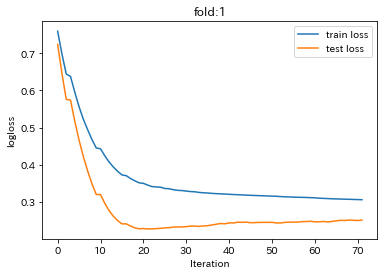

[I 2021-12-27 16:47:40,189] A new study created in memory with name: no-name-78b79bc7-aa61-440f-adfb-40d19e90f3fb


[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:40,900] Trial 0 finished with value: 0.16322445860716608 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.16322445860716608.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138513	Test's rmse: 0.163224
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:41,502] Trial 1 finished with value: 0.13951300627268312 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 0.13951300627268312.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135018	Test's rmse: 0.139513
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:42,050] Trial 2 finished with value: 0.13865784889724897 and parameters: {'feature_fraction': 0.8}. Best is trial 2 with value: 0.13865784889724897.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132057	Test's rmse: 0.138658
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:42,566] Trial 3 finished with value: 0.14113805081844225 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 2 with value: 0.13865784889724897.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140832	Test's rmse: 0.141138
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:43,179] Trial 4 finished with value: 0.15402090329646484 and parameters: {'feature_fraction': 0.5}. Best is trial 2 with value: 0.13865784889724897.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133245	Test's rmse: 0.154021
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:43,735] Trial 5 finished with value: 0.14255042142700264 and parameters: {'feature_fraction': 1.0}. Best is trial 2 with value: 0.13865784889724897.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14364	Test's rmse: 0.14255
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:44,290] Trial 6 finished with value: 0.14793563387487457 and parameters: {'feature_fraction': 0.6}. Best is trial 2 with value: 0.13865784889724897.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13314	Test's rmse: 0.147936
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:45,701] Trial 7 finished with value: 0.1411587486096182 and parameters: {'num_leaves': 99}. Best is trial 7 with value: 0.1411587486096182.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129689	Test's rmse: 0.141159
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:47,166] Trial 8 finished with value: 0.13957184743375628 and parameters: {'num_leaves': 100}. Best is trial 8 with value: 0.13957184743375628.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127901	Test's rmse: 0.139572
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:49,725] Trial 9 finished with value: 0.1394656693401479 and parameters: {'num_leaves': 187}. Best is trial 9 with value: 0.1394656693401479.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131702	Test's rmse: 0.139466
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:53,426] Trial 10 finished with value: 0.14462652397207 and parameters: {'num_leaves': 240}. Best is trial 9 with value: 0.1394656693401479.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132321	Test's rmse: 0.144627
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:54,819] Trial 11 finished with value: 0.14147253446650918 and parameters: {'num_leaves': 71}. Best is trial 9 with value: 0.1394656693401479.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130825	Test's rmse: 0.141473
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:57,381] Trial 12 finished with value: 0.1430546098689481 and parameters: {'num_leaves': 138}. Best is trial 9 with value: 0.1394656693401479.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135479	Test's rmse: 0.143055
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:58,174] Trial 13 finished with value: 0.13747743432288648 and parameters: {'num_leaves': 30}. Best is trial 13 with value: 0.13747743432288648.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132976	Test's rmse: 0.137477
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:47:58,459] Trial 14 finished with value: 0.14711077519018892 and parameters: {'num_leaves': 9}. Best is trial 13 with value: 0.13747743432288648.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.146049	Test's rmse: 0.147111
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:02,392] Trial 15 finished with value: 0.1408402688778152 and parameters: {'num_leaves': 228}. Best is trial 13 with value: 0.13747743432288648.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128154	Test's rmse: 0.14084
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:05,804] Trial 16 finished with value: 0.1430276681295514 and parameters: {'num_leaves': 206}. Best is trial 13 with value: 0.13747743432288648.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133543	Test's rmse: 0.143028
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:06,130] Trial 17 finished with value: 0.13705046596416934 and parameters: {'num_leaves': 11}. Best is trial 17 with value: 0.13705046596416934.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143275	Test's rmse: 0.13705
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.177788	Test's rmse: 0.155096


[I 2021-12-27 16:48:06,340] Trial 18 finished with value: 0.1550958064432669 and parameters: {'num_leaves': 4}. Best is trial 17 with value: 0.13705046596416934.


[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:07,268] Trial 19 finished with value: 0.13846448707816045 and parameters: {'num_leaves': 46}. Best is trial 17 with value: 0.13705046596416934.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132662	Test's rmse: 0.138464
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:08,237] Trial 20 finished with value: 0.13846448707816045 and parameters: {'num_leaves': 46}. Best is trial 17 with value: 0.13705046596416934.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132662	Test's rmse: 0.138464
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:09,053] Trial 21 finished with value: 0.13981630094692063 and parameters: {'num_leaves': 40}. Best is trial 17 with value: 0.13705046596416934.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129716	Test's rmse: 0.139816
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:11,042] Trial 22 finished with value: 0.1419012364869613 and parameters: {'num_leaves': 156}. Best is trial 17 with value: 0.13705046596416934.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132638	Test's rmse: 0.141901
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:12,101] Trial 23 finished with value: 0.1422535514705406 and parameters: {'num_leaves': 81}. Best is trial 17 with value: 0.13705046596416934.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138351	Test's rmse: 0.142254
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:12,585] Trial 24 finished with value: 0.13902812039752216 and parameters: {'num_leaves': 28}. Best is trial 17 with value: 0.13705046596416934.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13146	Test's rmse: 0.139028
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:13,536] Trial 25 finished with value: 0.1382539894782479 and parameters: {'num_leaves': 70}. Best is trial 17 with value: 0.13705046596416934.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130899	Test's rmse: 0.138254
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:15,054] Trial 26 finished with value: 0.14045663309284287 and parameters: {'num_leaves': 118}. Best is trial 17 with value: 0.13705046596416934.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.12847	Test's rmse: 0.140457
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:15,275] Trial 27 finished with value: 0.16172680334881995 and parameters: {'bagging_fraction': 0.5665322709743048, 'bagging_freq': 6}. Best is trial 27 with value: 0.16172680334881995.


Early stopping, best iteration is:
[35]	Train's rmse: 0.197123	Test's rmse: 0.161727
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:15,523] Trial 28 finished with value: 0.16159234425923966 and parameters: {'bagging_fraction': 0.5005200391560796, 'bagging_freq': 4}. Best is trial 28 with value: 0.16159234425923966.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.1765	Test's rmse: 0.161592
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:15,775] Trial 29 finished with value: 0.157896091111848 and parameters: {'bagging_fraction': 0.6810738165819308, 'bagging_freq': 4}. Best is trial 29 with value: 0.157896091111848.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.161971	Test's rmse: 0.157896
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:16,018] Trial 30 finished with value: 0.139257937074267 and parameters: {'bagging_fraction': 0.9523263648198788, 'bagging_freq': 1}. Best is trial 30 with value: 0.139257937074267.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141352	Test's rmse: 0.139258
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:16,266] Trial 31 finished with value: 0.14739554617220518 and parameters: {'bagging_fraction': 0.6339902342014119, 'bagging_freq': 7}. Best is trial 30 with value: 0.139257937074267.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168301	Test's rmse: 0.147396
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:16,512] Trial 32 finished with value: 0.14169155259661756 and parameters: {'bagging_fraction': 0.9269901852744953, 'bagging_freq': 1}. Best is trial 30 with value: 0.139257937074267.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15024	Test's rmse: 0.141692
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:16,799] Trial 33 finished with value: 0.15485607497748102 and parameters: {'bagging_fraction': 0.6558492681584829, 'bagging_freq': 1}. Best is trial 30 with value: 0.139257937074267.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.173398	Test's rmse: 0.154856
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:17,090] Trial 34 finished with value: 0.16423521118857315 and parameters: {'bagging_fraction': 0.4871084770062182, 'bagging_freq': 4}. Best is trial 30 with value: 0.139257937074267.


Did not meet early stopping. Best iteration is:
[97]	Train's rmse: 0.176187	Test's rmse: 0.164235
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:17,415] Trial 35 finished with value: 0.1419672937869546 and parameters: {'bagging_fraction': 0.860456073055084, 'bagging_freq': 2}. Best is trial 30 with value: 0.139257937074267.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.150365	Test's rmse: 0.141967
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:17,671] Trial 36 finished with value: 0.15242565654311327 and parameters: {'bagging_fraction': 0.8178439274061859, 'bagging_freq': 6}. Best is trial 30 with value: 0.139257937074267.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.170494	Test's rmse: 0.152426
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:17,915] Trial 37 finished with value: 0.13705046596416934 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 37 with value: 0.13705046596416934.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143275	Test's rmse: 0.13705
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:18,167] Trial 38 finished with value: 0.14302204712812885 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 37 with value: 0.13705046596416934.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136059	Test's rmse: 0.143022
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:18,414] Trial 39 finished with value: 0.1439814226130139 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 37 with value: 0.13705046596416934.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140696	Test's rmse: 0.143981
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:18,646] Trial 40 finished with value: 0.1431814660216971 and parameters: {'feature_fraction': 0.88}. Best is trial 37 with value: 0.13705046596416934.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.146483	Test's rmse: 0.143181
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:18,887] Trial 41 finished with value: 0.13705046596416934 and parameters: {'feature_fraction': 0.784}. Best is trial 37 with value: 0.13705046596416934.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143275	Test's rmse: 0.13705
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:19,204] Trial 42 finished with value: 0.13986535561937882 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 37 with value: 0.13705046596416934.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139242	Test's rmse: 0.139865
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:19,477] Trial 43 finished with value: 0.13705081853317275 and parameters: {'lambda_l1': 0.000216954515452277, 'lambda_l2': 2.9447206299299805e-06}. Best is trial 43 with value: 0.13705081853317275.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143276	Test's rmse: 0.137051
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:19,752] Trial 44 finished with value: 0.1370508493146486 and parameters: {'lambda_l1': 1.4869293323590493e-05, 'lambda_l2': 0.0006118760622531036}. Best is trial 43 with value: 0.13705081853317275.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143276	Test's rmse: 0.137051
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:20,096] Trial 45 finished with value: 0.13705047525346226 and parameters: {'lambda_l1': 5.752659045623598e-06, 'lambda_l2': 6.186554447983728e-08}. Best is trial 45 with value: 0.13705047525346226.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143275	Test's rmse: 0.13705
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 16:48:20,357] Trial 46 finished with value: 0.1488918010614501 and parameters: {'lambda_l1': 3.548151377293441, 'lambda_l2': 0.15347673695182934}. Best is trial 45 with value: 0.13705047525346226.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138853	Test's rmse: 0.148892
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:20,614] Trial 47 finished with value: 0.13705046622532932 and parameters: {'lambda_l1': 1.8720585701703558e-07, 'lambda_l2': 7.560141859961242e-08}. Best is trial 47 with value: 0.13705046622532932.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143275	Test's rmse: 0.13705
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:20,874] Trial 48 finished with value: 0.1499006808839741 and parameters: {'lambda_l1': 0.8632671490657338, 'lambda_l2': 1.071078079467339}. Best is trial 47 with value: 0.13705046622532932.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131741	Test's rmse: 0.149901
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:21,143] Trial 49 finished with value: 0.14357146091157108 and parameters: {'lambda_l1': 0.05173612264478097, 'lambda_l2': 0.5164470512240277}. Best is trial 47 with value: 0.13705046622532932.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131171	Test's rmse: 0.143571
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:21,406] Trial 50 finished with value: 0.14418518213606193 and parameters: {'lambda_l1': 0.9841972955648868, 'lambda_l2': 0.00016549544044704644}. Best is trial 47 with value: 0.13705046622532932.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135728	Test's rmse: 0.144185
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:21,659] Trial 51 finished with value: 0.1370505151926753 and parameters: {'lambda_l1': 4.488726860592897e-08, 'lambda_l2': 8.398841348482605e-05}. Best is trial 47 with value: 0.13705046622532932.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143275	Test's rmse: 0.137051
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:21,921] Trial 52 finished with value: 0.13705542487450872 and parameters: {'lambda_l1': 0.0044194147717686845, 'lambda_l2': 9.466934367013773e-08}. Best is trial 47 with value: 0.13705046622532932.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143345	Test's rmse: 0.137055
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:22,186] Trial 53 finished with value: 0.1370504676842883 and parameters: {'lambda_l1': 1.7542124025073885e-08, 'lambda_l2': 2.8663599361109543e-06}. Best is trial 47 with value: 0.13705046622532932.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143275	Test's rmse: 0.13705
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:22,492] Trial 54 finished with value: 0.1370504671623324 and parameters: {'lambda_l1': 1.5288260873859905e-08, 'lambda_l2': 2.2525060237725482e-06}. Best is trial 47 with value: 0.13705046622532932.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143275	Test's rmse: 0.13705
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:22,773] Trial 55 finished with value: 0.1370504679816215 and parameters: {'lambda_l1': 7.225477469676074e-07, 'lambda_l2': 1.537786518769843e-06}. Best is trial 47 with value: 0.13705046622532932.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143275	Test's rmse: 0.13705
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:23,034] Trial 56 finished with value: 0.13705046640637705 and parameters: {'lambda_l1': 2.860601893769168e-07, 'lambda_l2': 1.3962155016986428e-08}. Best is trial 47 with value: 0.13705046622532932.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143275	Test's rmse: 0.13705
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:23,314] Trial 57 finished with value: 0.13705046696230277 and parameters: {'lambda_l1': 7.207450477087011e-07, 'lambda_l2': 1.3184156218969866e-08}. Best is trial 47 with value: 0.13705046622532932.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143275	Test's rmse: 0.13705
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:23,574] Trial 58 finished with value: 0.1370507176131259 and parameters: {'lambda_l1': 0.00015559949961672944, 'lambda_l2': 1.1141643608553377e-08}. Best is trial 47 with value: 0.13705046622532932.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143275	Test's rmse: 0.137051
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:23,833] Trial 59 finished with value: 0.1370504666038147 and parameters: {'lambda_l1': 3.438613425771225e-07, 'lambda_l2': 3.39056472371884e-07}. Best is trial 47 with value: 0.13705046622532932.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143275	Test's rmse: 0.13705
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:24,082] Trial 60 finished with value: 0.144774814757992 and parameters: {'lambda_l1': 7.3171986101604635e-06, 'lambda_l2': 0.006778648552879509}. Best is trial 47 with value: 0.13705046622532932.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137408	Test's rmse: 0.144775
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:24,335] Trial 61 finished with value: 0.1370504820446727 and parameters: {'lambda_l1': 1.7934112771861894e-07, 'lambda_l2': 2.6944089842704106e-05}. Best is trial 47 with value: 0.13705046622532932.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143275	Test's rmse: 0.13705
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:24,626] Trial 62 finished with value: 0.13705524240495695 and parameters: {'lambda_l1': 0.004306783725869722, 'lambda_l2': 2.3729297565770806e-07}. Best is trial 47 with value: 0.13705046622532932.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143345	Test's rmse: 0.137055
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:24,870] Trial 63 finished with value: 0.1408812535129567 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.1408812535129567.


Early stopping, best iteration is:
[44]	Train's rmse: 0.0758644	Test's rmse: 0.140881
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:25,173] Trial 64 finished with value: 0.15277326226431992 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 0.1408812535129567.


Early stopping, best iteration is:
[49]	Train's rmse: 0.116104	Test's rmse: 0.152773
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:25,443] Trial 65 finished with value: 0.2007031897088027 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.1408812535129567.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.283451	Test's rmse: 0.200703
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:25,709] Trial 66 finished with value: 0.15375239976079458 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.1408812535129567.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.151888	Test's rmse: 0.153752
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10700, number of used features: 20
[LightGBM] [Info] Start training from score 0.387056
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:25,963] Trial 67 finished with value: 0.17801177842966176 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.1408812535129567.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.218524	Test's rmse: 0.178012


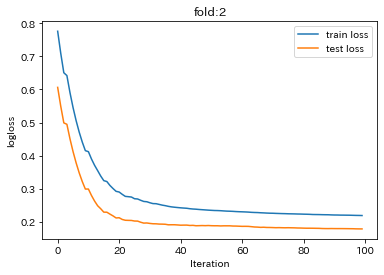

[I 2021-12-27 16:48:26,182] A new study created in memory with name: no-name-dc4d6668-82ab-4007-b41f-3516f3feff28


[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:26,734] Trial 0 finished with value: 0.09839499109168154 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.09839499109168154.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145267	Test's rmse: 0.098395
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:27,290] Trial 1 finished with value: 0.07606878669053532 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.07606878669053532.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133454	Test's rmse: 0.0760688
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:27,909] Trial 2 finished with value: 0.09656214425966018 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 0.07606878669053532.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140409	Test's rmse: 0.0965621
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:28,411] Trial 3 finished with value: 0.021515966371072868 and parameters: {'feature_fraction': 1.0}. Best is trial 3 with value: 0.021515966371072868.


Early stopping, best iteration is:
[45]	Train's rmse: 0.171356	Test's rmse: 0.021516
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:28,935] Trial 4 finished with value: 0.04423424044761344 and parameters: {'feature_fraction': 0.8}. Best is trial 3 with value: 0.021515966371072868.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136988	Test's rmse: 0.0442342
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:29,425] Trial 5 finished with value: 0.022400643422498926 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 3 with value: 0.021515966371072868.


Early stopping, best iteration is:
[44]	Train's rmse: 0.170059	Test's rmse: 0.0224006
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:30,135] Trial 6 finished with value: 0.0560347636640894 and parameters: {'feature_fraction': 0.7}. Best is trial 3 with value: 0.021515966371072868.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131369	Test's rmse: 0.0560348
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:31,226] Trial 7 finished with value: 0.021652454339389428 and parameters: {'num_leaves': 85}. Best is trial 7 with value: 0.021652454339389428.


Early stopping, best iteration is:
[44]	Train's rmse: 0.171098	Test's rmse: 0.0216525
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:34,183] Trial 8 finished with value: 0.029511516201892643 and parameters: {'num_leaves': 220}. Best is trial 7 with value: 0.021652454339389428.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154282	Test's rmse: 0.0295115
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:35,793] Trial 9 finished with value: 0.030720763603051315 and parameters: {'num_leaves': 107}. Best is trial 7 with value: 0.021652454339389428.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154054	Test's rmse: 0.0307208
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:37,836] Trial 10 finished with value: 0.021341368299279385 and parameters: {'num_leaves': 158}. Best is trial 10 with value: 0.021341368299279385.


Early stopping, best iteration is:
[48]	Train's rmse: 0.168064	Test's rmse: 0.0213414
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:39,477] Trial 11 finished with value: 0.03043931581454434 and parameters: {'num_leaves': 109}. Best is trial 10 with value: 0.021341368299279385.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.153942	Test's rmse: 0.0304393
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:41,822] Trial 12 finished with value: 0.02908451567831693 and parameters: {'num_leaves': 171}. Best is trial 10 with value: 0.021341368299279385.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154407	Test's rmse: 0.0290845
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:42,685] Trial 13 finished with value: 0.019478195384959793 and parameters: {'num_leaves': 54}. Best is trial 13 with value: 0.019478195384959793.


Early stopping, best iteration is:
[44]	Train's rmse: 0.170422	Test's rmse: 0.0194782
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:43,420] Trial 14 finished with value: 0.020287399706503374 and parameters: {'num_leaves': 36}. Best is trial 13 with value: 0.019478195384959793.


Early stopping, best iteration is:
[46]	Train's rmse: 0.169467	Test's rmse: 0.0202874
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:44,136] Trial 15 finished with value: 0.028333075820965465 and parameters: {'num_leaves': 16}. Best is trial 13 with value: 0.019478195384959793.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154541	Test's rmse: 0.0283331
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:46,567] Trial 16 finished with value: 0.021760044792350174 and parameters: {'num_leaves': 135}. Best is trial 13 with value: 0.019478195384959793.


Early stopping, best iteration is:
[44]	Train's rmse: 0.170225	Test's rmse: 0.02176
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:47,633] Trial 17 finished with value: 0.021453744768765676 and parameters: {'num_leaves': 58}. Best is trial 13 with value: 0.019478195384959793.


Early stopping, best iteration is:
[48]	Train's rmse: 0.170709	Test's rmse: 0.0214537
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:47,872] Trial 18 finished with value: 0.04120256291716419 and parameters: {'num_leaves': 3}. Best is trial 13 with value: 0.019478195384959793.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.194592	Test's rmse: 0.0412026
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:49,324] Trial 19 finished with value: 0.019954701337619417 and parameters: {'num_leaves': 50}. Best is trial 13 with value: 0.019478195384959793.


Early stopping, best iteration is:
[44]	Train's rmse: 0.170122	Test's rmse: 0.0199547
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:50,447] Trial 20 finished with value: 0.021453744768765676 and parameters: {'num_leaves': 58}. Best is trial 13 with value: 0.019478195384959793.


Early stopping, best iteration is:
[48]	Train's rmse: 0.170709	Test's rmse: 0.0214537
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:52,425] Trial 21 finished with value: 0.030466327317699205 and parameters: {'num_leaves': 76}. Best is trial 13 with value: 0.019478195384959793.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154251	Test's rmse: 0.0304663
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:53,463] Trial 22 finished with value: 0.02052862454752579 and parameters: {'num_leaves': 37}. Best is trial 13 with value: 0.019478195384959793.


Early stopping, best iteration is:
[46]	Train's rmse: 0.169815	Test's rmse: 0.0205286
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:48:58,443] Trial 23 finished with value: 0.03010118664169593 and parameters: {'num_leaves': 216}. Best is trial 13 with value: 0.019478195384959793.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154269	Test's rmse: 0.0301012
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:03,630] Trial 24 finished with value: 0.030145932147014883 and parameters: {'num_leaves': 250}. Best is trial 13 with value: 0.019478195384959793.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154154	Test's rmse: 0.0301459
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:04,549] Trial 25 finished with value: 0.020372214583501205 and parameters: {'num_leaves': 34}. Best is trial 13 with value: 0.019478195384959793.


Early stopping, best iteration is:
[44]	Train's rmse: 0.170515	Test's rmse: 0.0203722
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:07,197] Trial 26 finished with value: 0.02176082152996028 and parameters: {'num_leaves': 93}. Best is trial 13 with value: 0.019478195384959793.


Early stopping, best iteration is:
[43]	Train's rmse: 0.171681	Test's rmse: 0.0217608
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:08,425] Trial 27 finished with value: 0.029096108605804298 and parameters: {'bagging_fraction': 0.8698492732370683, 'bagging_freq': 7}. Best is trial 27 with value: 0.029096108605804298.


Early stopping, best iteration is:
[39]	Train's rmse: 0.188554	Test's rmse: 0.0290961
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:09,258] Trial 28 finished with value: 0.029943427227479055 and parameters: {'bagging_fraction': 0.8210600168392258, 'bagging_freq': 5}. Best is trial 27 with value: 0.029096108605804298.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.181006	Test's rmse: 0.0299434
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:10,163] Trial 29 finished with value: 0.028546118504349766 and parameters: {'bagging_fraction': 0.5269525005719297, 'bagging_freq': 6}. Best is trial 29 with value: 0.028546118504349766.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.185862	Test's rmse: 0.0285461
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:10,930] Trial 30 finished with value: 0.028047812610263213 and parameters: {'bagging_fraction': 0.5612256572523545, 'bagging_freq': 4}. Best is trial 30 with value: 0.028047812610263213.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.185228	Test's rmse: 0.0280478
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:11,624] Trial 31 finished with value: 0.029789045379079497 and parameters: {'bagging_fraction': 0.8758960836238271, 'bagging_freq': 6}. Best is trial 30 with value: 0.028047812610263213.


Early stopping, best iteration is:
[36]	Train's rmse: 0.193826	Test's rmse: 0.029789
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:12,398] Trial 32 finished with value: 0.02797272421196249 and parameters: {'bagging_fraction': 0.8529703319849229, 'bagging_freq': 7}. Best is trial 32 with value: 0.02797272421196249.


Early stopping, best iteration is:
[41]	Train's rmse: 0.187703	Test's rmse: 0.0279727
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:13,161] Trial 33 finished with value: 0.02448945146219218 and parameters: {'bagging_fraction': 0.9408706944745412, 'bagging_freq': 4}. Best is trial 33 with value: 0.02448945146219218.


Early stopping, best iteration is:
[43]	Train's rmse: 0.177572	Test's rmse: 0.0244895
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:14,004] Trial 34 finished with value: 0.03295057803602872 and parameters: {'bagging_fraction': 0.9047728193847852, 'bagging_freq': 4}. Best is trial 33 with value: 0.02448945146219218.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.166828	Test's rmse: 0.0329506
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:14,770] Trial 35 finished with value: 0.03087249972402706 and parameters: {'bagging_fraction': 0.8289487458135086, 'bagging_freq': 6}. Best is trial 33 with value: 0.02448945146219218.


Early stopping, best iteration is:
[36]	Train's rmse: 0.192403	Test's rmse: 0.0308725
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:15,461] Trial 36 finished with value: 0.02543146871119832 and parameters: {'bagging_fraction': 0.6311165537438329, 'bagging_freq': 7}. Best is trial 33 with value: 0.02448945146219218.


Early stopping, best iteration is:
[35]	Train's rmse: 0.198881	Test's rmse: 0.0254315
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:16,190] Trial 37 finished with value: 0.023552100488698494 and parameters: {'feature_fraction': 0.92}. Best is trial 37 with value: 0.023552100488698494.


Early stopping, best iteration is:
[43]	Train's rmse: 0.167578	Test's rmse: 0.0235521
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:16,966] Trial 38 finished with value: 0.019478195384959793 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 38 with value: 0.019478195384959793.


Early stopping, best iteration is:
[44]	Train's rmse: 0.170422	Test's rmse: 0.0194782
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:17,782] Trial 39 finished with value: 0.020445619698537948 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 38 with value: 0.019478195384959793.


Early stopping, best iteration is:
[46]	Train's rmse: 0.175678	Test's rmse: 0.0204456
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:18,551] Trial 40 finished with value: 0.019478195354345744 and parameters: {'lambda_l1': 6.170996792077658e-08, 'lambda_l2': 7.447299838023756e-07}. Best is trial 40 with value: 0.019478195354345744.


Early stopping, best iteration is:
[44]	Train's rmse: 0.170422	Test's rmse: 0.0194782
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2021-12-27 16:49:18,975] Trial 41 finished with value: 0.020160820294175756 and parameters: {'lambda_l1': 1.2379980754779154, 'lambda_l2': 7.097662815738932e-06}. Best is trial 40 with value: 0.019478195354345744.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 16:49:19,893] Trial 42 finished with value: 0.029540820657939948 and parameters: {'lambda_l1': 0.014061088104473273, 'lambda_l2': 0.11864399558108028}. Best is trial 40 with value: 0.019478195354345744.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.152752	Test's rmse: 0.0295408
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:20,751] Trial 43 finished with value: 0.029441421367609726 and parameters: {'lambda_l1': 0.00023856367438711404, 'lambda_l2': 0.5809299217331824}. Best is trial 40 with value: 0.019478195354345744.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15336	Test's rmse: 0.0294414
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2021-12-27 16:49:21,342] Trial 44 finished with value: 0.02062541808562368 and parameters: {'lambda_l1': 0.314405409724745, 'lambda_l2': 0.00010626825278772643}. Best is trial 40 with value: 0.019478195354345744.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[44]	Train's rmse: 0.171075	Test's rmse: 0.0206254
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2021-12-27 16:49:22,107] Trial 45 finished with value: 0.02990239441145262 and parameters: {'lambda_l1': 0.13092463702349966, 'lambda_l2': 4.928995153870369e-07}. Best is trial 40 with value: 0.019478195354345744.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.151729	Test's rmse: 0.0299024
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:22,931] Trial 46 finished with value: 0.021418087929743264 and parameters: {'lambda_l1': 0.0004778046533706171, 'lambda_l2': 0.31026265198214004}. Best is trial 40 with value: 0.019478195354345744.


Early stopping, best iteration is:
[47]	Train's rmse: 0.171279	Test's rmse: 0.0214181
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2021-12-27 16:49:23,417] Trial 47 finished with value: 0.025831130527424064 and parameters: {'lambda_l1': 0.8156833551786178, 'lambda_l2': 5.963590985880178}. Best is trial 40 with value: 0.019478195354345744.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 16:49:23,808] Trial 48 finished with value: 0.025829265827296232 and parameters: {'lambda_l1': 1.3258204534345235, 'lambda_l2': 7.705033026831381}. Best is trial 40 with value: 0.019478195354345744.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 16:49:24,086] Trial 49 finished with value: 0.028851384559826443 and parameters: {'lambda_l1': 7.6136461621720795, 'lambda_l2': 0.2357681957847136}. Best is trial 40 with value: 0.019478195354345744.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 16:49:24,833] Trial 50 finished with value: 0.019478195417878406 and parameters: {'lambda_l1': 1.4583260749953169e-08, 'lambda_l2': 1.0360187303669327e-08}. Best is trial 40 with value: 0.019478195354345744.


Early stopping, best iteration is:
[44]	Train's rmse: 0.170422	Test's rmse: 0.0194782
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:25,635] Trial 51 finished with value: 0.019478195415932372 and parameters: {'lambda_l1': 1.1770811034550101e-08, 'lambda_l2': 1.6355306550126702e-08}. Best is trial 40 with value: 0.019478195354345744.


Early stopping, best iteration is:
[44]	Train's rmse: 0.170422	Test's rmse: 0.0194782
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:26,423] Trial 52 finished with value: 0.019478195399898795 and parameters: {'lambda_l1': 1.3314371993284692e-08, 'lambda_l2': 4.266654519047057e-08}. Best is trial 40 with value: 0.019478195354345744.


Early stopping, best iteration is:
[44]	Train's rmse: 0.170422	Test's rmse: 0.0194782
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:27,333] Trial 53 finished with value: 0.019478196141575525 and parameters: {'lambda_l1': 8.917582114504236e-07, 'lambda_l2': 6.342711227041861e-07}. Best is trial 40 with value: 0.019478195354345744.


Early stopping, best iteration is:
[44]	Train's rmse: 0.170422	Test's rmse: 0.0194782
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:28,156] Trial 54 finished with value: 0.02052458398398529 and parameters: {'lambda_l1': 6.762065572576751e-07, 'lambda_l2': 0.0013482300317183848}. Best is trial 40 with value: 0.019478195354345744.


Early stopping, best iteration is:
[42]	Train's rmse: 0.171661	Test's rmse: 0.0205246
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:28,981] Trial 55 finished with value: 0.019478196095359952 and parameters: {'lambda_l1': 6.749763830739042e-07, 'lambda_l2': 2.5128318802736576e-07}. Best is trial 40 with value: 0.019478195354345744.


Early stopping, best iteration is:
[44]	Train's rmse: 0.170422	Test's rmse: 0.0194782
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:29,793] Trial 56 finished with value: 0.020179144745691463 and parameters: {'lambda_l1': 1.262379022999435e-05, 'lambda_l2': 1.7169863941385894e-05}. Best is trial 40 with value: 0.019478195354345744.


Early stopping, best iteration is:
[46]	Train's rmse: 0.169804	Test's rmse: 0.0201791
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:30,639] Trial 57 finished with value: 0.02032850817546039 and parameters: {'lambda_l1': 7.140578547452608e-08, 'lambda_l2': 0.0016662455856907056}. Best is trial 40 with value: 0.019478195354345744.


Early stopping, best iteration is:
[46]	Train's rmse: 0.169849	Test's rmse: 0.0203285
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:31,431] Trial 58 finished with value: 0.02017914692939401 and parameters: {'lambda_l1': 1.0592543828929509e-05, 'lambda_l2': 4.708172981347366e-06}. Best is trial 40 with value: 0.019478195354345744.


Early stopping, best iteration is:
[46]	Train's rmse: 0.169804	Test's rmse: 0.0201791
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:32,260] Trial 59 finished with value: 0.019478195484407757 and parameters: {'lambda_l1': 1.1734136813290982e-07, 'lambda_l2': 7.003140195541184e-08}. Best is trial 40 with value: 0.019478195354345744.


Early stopping, best iteration is:
[44]	Train's rmse: 0.170422	Test's rmse: 0.0194782
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:33,072] Trial 60 finished with value: 0.026820784625208826 and parameters: {'min_child_samples': 10}. Best is trial 60 with value: 0.026820784625208826.


Early stopping, best iteration is:
[44]	Train's rmse: 0.115441	Test's rmse: 0.0268208
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:34,009] Trial 61 finished with value: 0.05652627900219536 and parameters: {'min_child_samples': 50}. Best is trial 60 with value: 0.026820784625208826.


Early stopping, best iteration is:
[39]	Train's rmse: 0.260197	Test's rmse: 0.0565263
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:34,710] Trial 62 finished with value: 0.09210201046951925 and parameters: {'min_child_samples': 100}. Best is trial 60 with value: 0.026820784625208826.


Early stopping, best iteration is:
[27]	Train's rmse: 0.320858	Test's rmse: 0.092102
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:35,471] Trial 63 finished with value: 0.026326110239211883 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.026326110239211883.


Early stopping, best iteration is:
[40]	Train's rmse: 0.0532849	Test's rmse: 0.0263261
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 10507, number of used features: 20
[LightGBM] [Info] Start training from score 0.397084
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:36,322] Trial 64 finished with value: 0.02759597761555463 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.026326110239211883.


Early stopping, best iteration is:
[47]	Train's rmse: 0.176661	Test's rmse: 0.027596


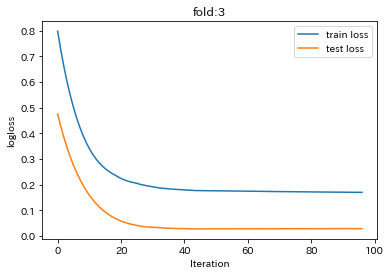

[I 2021-12-27 16:49:36,564] A new study created in memory with name: no-name-43b1d876-8acc-457f-9b21-08871aa993f4


[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:37,138] Trial 0 finished with value: 0.36414511244985315 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.36414511244985315.


Early stopping, best iteration is:
[43]	Train's rmse: 0.153791	Test's rmse: 0.364145
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:37,732] Trial 1 finished with value: 0.36166103144322165 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 0.36166103144322165.


Early stopping, best iteration is:
[37]	Train's rmse: 0.155527	Test's rmse: 0.361661
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:38,322] Trial 2 finished with value: 0.39948385806992515 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 0.36166103144322165.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.123503	Test's rmse: 0.399484
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:38,941] Trial 3 finished with value: 0.38764520770701594 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.36166103144322165.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.123402	Test's rmse: 0.387645
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:39,446] Trial 4 finished with value: 0.3826587134787574 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 0.36166103144322165.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.125217	Test's rmse: 0.382659
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:39,884] Trial 5 finished with value: 0.3586230618197376 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 5 with value: 0.3586230618197376.


Early stopping, best iteration is:
[34]	Train's rmse: 0.159544	Test's rmse: 0.358623
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:40,471] Trial 6 finished with value: 0.4092260907331102 and parameters: {'feature_fraction': 0.4}. Best is trial 5 with value: 0.3586230618197376.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.126172	Test's rmse: 0.409226
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:41,498] Trial 7 finished with value: 0.36027416089519554 and parameters: {'num_leaves': 85}. Best is trial 7 with value: 0.36027416089519554.


Early stopping, best iteration is:
[35]	Train's rmse: 0.159188	Test's rmse: 0.360274
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:43,072] Trial 8 finished with value: 0.3601796574199814 and parameters: {'num_leaves': 129}. Best is trial 8 with value: 0.3601796574199814.


Early stopping, best iteration is:
[35]	Train's rmse: 0.159208	Test's rmse: 0.36018
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:45,178] Trial 9 finished with value: 0.3601975102821833 and parameters: {'num_leaves': 216}. Best is trial 8 with value: 0.3601796574199814.


Early stopping, best iteration is:
[35]	Train's rmse: 0.159186	Test's rmse: 0.360198
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:46,215] Trial 10 finished with value: 0.36023586093223525 and parameters: {'num_leaves': 92}. Best is trial 8 with value: 0.3601796574199814.


Early stopping, best iteration is:
[35]	Train's rmse: 0.159194	Test's rmse: 0.360236
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:47,953] Trial 11 finished with value: 0.3601385646514481 and parameters: {'num_leaves': 172}. Best is trial 11 with value: 0.3601385646514481.


Early stopping, best iteration is:
[35]	Train's rmse: 0.15915	Test's rmse: 0.360139
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:50,439] Trial 12 finished with value: 0.3601404863429387 and parameters: {'num_leaves': 228}. Best is trial 11 with value: 0.3601385646514481.


Early stopping, best iteration is:
[35]	Train's rmse: 0.159136	Test's rmse: 0.36014
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:52,429] Trial 13 finished with value: 0.3601359505756255 and parameters: {'num_leaves': 138}. Best is trial 13 with value: 0.3601359505756255.


Early stopping, best iteration is:
[35]	Train's rmse: 0.159199	Test's rmse: 0.360136
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:54,838] Trial 14 finished with value: 0.3601491317439932 and parameters: {'num_leaves': 181}. Best is trial 13 with value: 0.3601359505756255.


Early stopping, best iteration is:
[35]	Train's rmse: 0.159151	Test's rmse: 0.360149
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:56,640] Trial 15 finished with value: 0.36013867083358103 and parameters: {'num_leaves': 135}. Best is trial 13 with value: 0.3601359505756255.


Early stopping, best iteration is:
[35]	Train's rmse: 0.159168	Test's rmse: 0.360139
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:57,940] Trial 16 finished with value: 0.36012657026096195 and parameters: {'num_leaves': 95}. Best is trial 16 with value: 0.36012657026096195.


Early stopping, best iteration is:
[35]	Train's rmse: 0.159189	Test's rmse: 0.360127
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:58,209] Trial 17 finished with value: 0.3472137825204541 and parameters: {'num_leaves': 9}. Best is trial 17 with value: 0.3472137825204541.


Early stopping, best iteration is:
[35]	Train's rmse: 0.158317	Test's rmse: 0.347214
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	Train's rmse: 0.161489	Test's rmse: 0.352071


[I 2021-12-27 16:49:58,395] Trial 18 finished with value: 0.3520709419669942 and parameters: {'num_leaves': 5}. Best is trial 17 with value: 0.3472137825204541.
[I 2021-12-27 16:49:58,595] Trial 19 finished with value: 0.33168561793499507 and parameters: {'num_leaves': 2}. Best is trial 19 with value: 0.33168561793499507.


[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.197686	Test's rmse: 0.331686
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	Train's rmse: 0.158317	Test's rmse: 0.347214


[I 2021-12-27 16:49:58,837] Trial 20 finished with value: 0.3472137825204541 and parameters: {'num_leaves': 9}. Best is trial 19 with value: 0.33168561793499507.


[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:49:59,507] Trial 21 finished with value: 0.3592881093565679 and parameters: {'num_leaves': 43}. Best is trial 19 with value: 0.33168561793499507.


Early stopping, best iteration is:
[35]	Train's rmse: 0.159007	Test's rmse: 0.359288
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:50:00,192] Trial 22 finished with value: 0.3592881093565679 and parameters: {'num_leaves': 43}. Best is trial 19 with value: 0.33168561793499507.


Early stopping, best iteration is:
[35]	Train's rmse: 0.159007	Test's rmse: 0.359288
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:50:01,029] Trial 23 finished with value: 0.36355223477872145 and parameters: {'num_leaves': 54}. Best is trial 19 with value: 0.33168561793499507.


Early stopping, best iteration is:
[34]	Train's rmse: 0.160148	Test's rmse: 0.363552
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:50:01,529] Trial 24 finished with value: 0.36164424510582915 and parameters: {'num_leaves': 23}. Best is trial 19 with value: 0.33168561793499507.


Early stopping, best iteration is:
[34]	Train's rmse: 0.159825	Test's rmse: 0.361644
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:50:02,639] Trial 25 finished with value: 0.3604874103443991 and parameters: {'num_leaves': 71}. Best is trial 19 with value: 0.33168561793499507.


Early stopping, best iteration is:
[35]	Train's rmse: 0.159245	Test's rmse: 0.360487
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:50:03,116] Trial 26 finished with value: 0.3541106137892034 and parameters: {'num_leaves': 27}. Best is trial 19 with value: 0.33168561793499507.
[I 2021-12-27 16:50:03,285] Trial 27 finished with value: 0.3284870016157199 and parameters: {'bagging_fraction': 0.9552089019844294, 'bagging_freq': 1}. Best is trial 27 with value: 0.3284870016157199.


Early stopping, best iteration is:
[34]	Train's rmse: 0.158981	Test's rmse: 0.354111
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.197443	Test's rmse: 0.328487


[I 2021-12-27 16:50:03,466] Trial 28 finished with value: 0.32818581283739334 and parameters: {'bagging_fraction': 0.9148586628993831, 'bagging_freq': 7}. Best is trial 28 with value: 0.32818581283739334.


[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.197319	Test's rmse: 0.328186
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651


[I 2021-12-27 16:50:03,615] Trial 29 finished with value: 0.32196754410060785 and parameters: {'bagging_fraction': 0.5662161961273063, 'bagging_freq': 5}. Best is trial 29 with value: 0.32196754410060785.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.199139	Test's rmse: 0.321968
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:50:03,772] Trial 30 finished with value: 0.32592211726302384 and parameters: {'bagging_fraction': 0.7504036946671999, 'bagging_freq': 1}. Best is trial 29 with value: 0.32196754410060785.
[I 2021-12-27 16:50:03,936] Trial 31 finished with value: 0.33148738244333636 and parameters: {'bagging_fraction': 0.6139699693181626, 'bagging_freq': 2}. Best is trial 29 with value: 0.32196754410060785.


Did not meet early stopping. Best iteration is:
[97]	Train's rmse: 0.197747	Test's rmse: 0.325922
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[90]	Train's rmse: 0.198711	Test's rmse: 0.331487
[LightGBM] [Info] Total Bins 2278


[I 2021-12-27 16:50:04,088] Trial 32 finished with value: 0.3247773927265438 and parameters: {'bagging_fraction': 0.7424626263031222, 'bagging_freq': 6}. Best is trial 29 with value: 0.32196754410060785.


[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.197455	Test's rmse: 0.324777
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:50:04,246] Trial 33 finished with value: 0.32478347553615206 and parameters: {'bagging_fraction': 0.7255760878075506, 'bagging_freq': 7}. Best is trial 29 with value: 0.32196754410060785.
[I 2021-12-27 16:50:04,400] Trial 34 finished with value: 0.3252080970634077 and parameters: {'bagging_fraction': 0.6239693603833832, 'bagging_freq': 1}. Best is trial 29 with value: 0.32196754410060785.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.198316	Test's rmse: 0.324783
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[97]	Train's rmse: 0.197712	Test's rmse: 0.325208
[LightGBM] [Info] Total Bins 2278


[I 2021-12-27 16:50:04,551] Trial 35 finished with value: 0.33068056760397524 and parameters: {'bagging_fraction': 0.695011077771194, 'bagging_freq': 7}. Best is trial 29 with value: 0.32196754410060785.


[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.198428	Test's rmse: 0.330681
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:50:04,717] Trial 36 finished with value: 0.3278062802090135 and parameters: {'bagging_fraction': 0.8772556237901813, 'bagging_freq': 7}. Best is trial 29 with value: 0.32196754410060785.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.197244	Test's rmse: 0.327806
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.198874	Test's rmse: 0.321601


[I 2021-12-27 16:50:04,906] Trial 37 finished with value: 0.321601231398523 and parameters: {'feature_fraction': 0.9799999999999999}. Best is trial 37 with value: 0.321601231398523.
[I 2021-12-27 16:50:05,057] Trial 38 finished with value: 0.32270413988229174 and parameters: {'feature_fraction': 0.948}. Best is trial 37 with value: 0.321601231398523.


[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.19892	Test's rmse: 0.322704
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:50:05,207] Trial 39 finished with value: 0.32174341512236776 and parameters: {'feature_fraction': 0.852}. Best is trial 37 with value: 0.321601231398523.
[I 2021-12-27 16:50:05,355] Trial 40 finished with value: 0.32196754410060785 and parameters: {'feature_fraction': 0.9159999999999999}. Best is trial 37 with value: 0.321601231398523.


Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.198867	Test's rmse: 0.321743
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.199139	Test's rmse: 0.321968
[LightGBM] [Info] Total Bins 2278


[I 2021-12-27 16:50:05,507] Trial 41 finished with value: 0.32196754410060785 and parameters: {'feature_fraction': 0.8839999999999999}. Best is trial 37 with value: 0.321601231398523.


[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.199139	Test's rmse: 0.321968
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:50:05,656] Trial 42 finished with value: 0.32439927338511837 and parameters: {'feature_fraction': 0.82}. Best is trial 37 with value: 0.321601231398523.
[I 2021-12-27 16:50:05,815] Trial 43 finished with value: 0.3216071210750364 and parameters: {'lambda_l1': 0.00748481180449944, 'lambda_l2': 3.1441608282007906e-05}. Best is trial 43 with value: 0.3216071210750364.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.198999	Test's rmse: 0.324399
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.198874	Test's rmse: 0.321607
[LightGBM] [Info] Total Bins 2278


[I 2021-12-27 16:50:05,973] Trial 44 finished with value: 0.3216012314640966 and parameters: {'lambda_l1': 2.601514072398505e-08, 'lambda_l2': 1.5274316616363117e-07}. Best is trial 44 with value: 0.3216012314640966.


[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.198874	Test's rmse: 0.321601
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651


[I 2021-12-27 16:50:06,127] Trial 45 finished with value: 0.3216022577721308 and parameters: {'lambda_l1': 0.000899079496758875, 'lambda_l2': 0.0004384159288172201}. Best is trial 44 with value: 0.3216012314640966.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.198874	Test's rmse: 0.321602
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:50:06,288] Trial 46 finished with value: 0.3217412218221979 and parameters: {'lambda_l1': 0.12644395069130251, 'lambda_l2': 0.053015071453836}. Best is trial 44 with value: 0.3216012314640966.
[I 2021-12-27 16:50:06,458] Trial 47 finished with value: 0.32160124113367056 and parameters: {'lambda_l1': 1.1891314208941903e-07, 'lambda_l2': 1.3204736610490765e-05}. Best is trial 44 with value: 0.3216012314640966.


Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.19888	Test's rmse: 0.321741
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.198874	Test's rmse: 0.321601


[I 2021-12-27 16:50:06,610] Trial 48 finished with value: 0.32294335973889987 and parameters: {'lambda_l1': 1.1437041425961456, 'lambda_l2': 9.135915270430932e-08}. Best is trial 44 with value: 0.3216012314640966.


[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.198744	Test's rmse: 0.322943
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:50:06,765] Trial 49 finished with value: 0.32403377012357415 and parameters: {'lambda_l1': 7.81683245332643e-05, 'lambda_l2': 3.2205473151753825}. Best is trial 44 with value: 0.3216012314640966.
[I 2021-12-27 16:50:06,916] Trial 50 finished with value: 0.3228323753908243 and parameters: {'lambda_l1': 4.161322144840948e-05, 'lambda_l2': 1.3518546776270814}. Best is trial 44 with value: 0.3216012314640966.


Did not meet early stopping. Best iteration is:
[92]	Train's rmse: 0.198844	Test's rmse: 0.324034
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[92]	Train's rmse: 0.198852	Test's rmse: 0.322832
[LightGBM] [Info] Total Bins 2278


[I 2021-12-27 16:50:07,097] Trial 51 finished with value: 0.321906375006394 and parameters: {'lambda_l1': 9.733665710002456e-06, 'lambda_l2': 0.5843352510951914}. Best is trial 44 with value: 0.3216012314640966.


[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.198905	Test's rmse: 0.321906
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651


[I 2021-12-27 16:50:07,261] Trial 52 finished with value: 0.3238103525864259 and parameters: {'lambda_l1': 0.009257648692679624, 'lambda_l2': 0.6469497594408796}. Best is trial 44 with value: 0.3216012314640966.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[92]	Train's rmse: 0.198834	Test's rmse: 0.32381
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:50:07,473] Trial 53 finished with value: 0.32160123143286606 and parameters: {'lambda_l1': 2.771827996590973e-08, 'lambda_l2': 1.0885293393653332e-07}. Best is trial 53 with value: 0.32160123143286606.
[I 2021-12-27 16:50:07,641] Trial 54 finished with value: 0.32160123132225665 and parameters: {'lambda_l1': 1.288910326479947e-08, 'lambda_l2': 1.013987944390773e-08}. Best is trial 54 with value: 0.32160123132225665.


Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.198874	Test's rmse: 0.321601
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.198874	Test's rmse: 0.321601


[I 2021-12-27 16:50:07,805] Trial 55 finished with value: 0.3216012320970845 and parameters: {'lambda_l1': 9.661432781842896e-07, 'lambda_l2': 2.863164142557046e-08}. Best is trial 54 with value: 0.32160123132225665.


[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.198874	Test's rmse: 0.321601
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651


[I 2021-12-27 16:50:07,975] Trial 56 finished with value: 0.3216012321924448 and parameters: {'lambda_l1': 1.0550153116500817e-08, 'lambda_l2': 1.4151949993913671e-06}. Best is trial 54 with value: 0.32160123132225665.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.198874	Test's rmse: 0.321601
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:50:08,142] Trial 57 finished with value: 0.3216012320359197 and parameters: {'lambda_l1': 9.41871938528506e-07, 'lambda_l2': 1.0520871959475976e-08}. Best is trial 54 with value: 0.32160123132225665.


Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.198874	Test's rmse: 0.321601
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.198874	Test's rmse: 0.321601


[I 2021-12-27 16:50:08,339] Trial 58 finished with value: 0.32160123225974463 and parameters: {'lambda_l1': 5.131585216940999e-07, 'lambda_l2': 7.263211222861487e-07}. Best is trial 54 with value: 0.32160123132225665.
[I 2021-12-27 16:50:08,506] Trial 59 finished with value: 0.32160284934218647 and parameters: {'lambda_l1': 5.002987808048684e-06, 'lambda_l2': 0.002197491411316899}. Best is trial 54 with value: 0.32160123132225665.


[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.198874	Test's rmse: 0.321603
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651


[I 2021-12-27 16:50:08,686] Trial 60 finished with value: 0.3216012337660029 and parameters: {'lambda_l1': 4.795947234830795e-08, 'lambda_l2': 3.4563402791448684e-06}. Best is trial 54 with value: 0.32160123132225665.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.198874	Test's rmse: 0.321601
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:50:08,854] Trial 61 finished with value: 0.3216012317079642 and parameters: {'lambda_l1': 1.7636989854587428e-07, 'lambda_l2': 3.3237436464284073e-07}. Best is trial 54 with value: 0.32160123132225665.
[I 2021-12-27 16:50:09,027] Trial 62 finished with value: 0.32349094603957557 and parameters: {'lambda_l1': 6.795556341475523, 'lambda_l2': 6.083486962902685e-05}. Best is trial 54 with value: 0.32160123132225665.


Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.198874	Test's rmse: 0.321601
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.199136	Test's rmse: 0.323491


[I 2021-12-27 16:50:09,189] Trial 63 finished with value: 0.32247317832655054 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 0.32247317832655054.


[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.198317	Test's rmse: 0.322473
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:50:09,344] Trial 64 finished with value: 0.3239456655692165 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.32247317832655054.
[I 2021-12-27 16:50:09,499] Trial 65 finished with value: 0.4215990875442609 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.32247317832655054.


Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.198278	Test's rmse: 0.323946
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.2412	Test's rmse: 0.421599
[LightGBM] [Info] Total Bins 2278


[I 2021-12-27 16:50:09,657] Trial 66 finished with value: 0.5180841445685845 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.32247317832655054.


[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.292905	Test's rmse: 0.518084
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 20
[LightGBM] [Info] Start training from score 0.354651
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 16:50:09,852] Trial 67 finished with value: 0.33450760225069925 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.32247317832655054.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.201136	Test's rmse: 0.334508


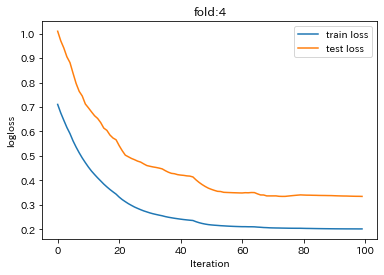

RMSE: [0.30885677168445047, 0.09045985928200755, 0.13705046894497297, 0.019478195651004917, 0.3216012304592107]
RMSE: 0.17548930520432932


In [7]:
# 学習・推論
gkf = GroupKFold(n_splits=5)

groups = X_train_dropna["Genre"]

params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': 'rmse',             # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'deterministic':True,         # 再現性確保用のパラメータ
          'force_row_wise':True,        # 再現性確保用のパラメータ
          'seed': SEED                   # シード値
          }

best_params, history = {}, []

cv_result = []

for fold, (train_index, test_index) in enumerate(gkf.split(X_train_dropna, y_train_dropna, groups)):
    X_train_gkf, X_test_gkf = X_train_dropna.iloc[train_index], X_train_dropna.iloc[test_index]
    y_train_gkf, y_test_gkf = y_train_dropna.iloc[train_index], y_train_dropna.iloc[test_index]

    # 学習、推論
    lgb_train = opt_lgb.Dataset(X_train_gkf, y_train_gkf)
    lgb_test = opt_lgb.Dataset(X_test_gkf, y_test_gkf, reference=lgb_train)

    lgb_results = {}                                    # 学習の履歴を入れる入物

    model = opt_lgb.LightGBMTuner(
                    params,                    # ハイパーパラメータをセット
                    train_set = lgb_train,              # 訓練データを訓練用にセット
                    valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                    valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                    num_boost_round=100,              # 計算回数
                    early_stopping_rounds=50,         # アーリーストッピング設定
                    evals_result=lgb_results,
                    show_progress_bar = False,        # プログレスバーの非表示
                    verbose_eval=-1,                  # ログを最後の1つだけ表示
                    )  
    
    # 訓練の実施
    model.run()

    best_params = model.best_params
    best_model = model.get_best_booster()

    # 損失推移を表示
    loss_train = lgb_results['Train']['rmse']
    loss_test = lgb_results['Test']['rmse']   
    
    fig = plt.figure()
    
    plt.xlabel('Iteration')
    plt.ylabel('logloss')

    plt.title(f"fold:{fold}")
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='test loss')
    
    plt.legend()
    plt.show()

    # 推論
    y_pred = best_model.predict(X_test_gkf)

    # 評価
    rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)
    cv_result.append(rmse)

print("RMSE:", cv_result)
print("RMSE:", np.mean(cv_result))

## Stacking

### 1層目 各モデルの予測結果を集計

In [11]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from catboost import CatBoostRegressor

In [12]:
models = {
    "ridge":Ridge(random_state=SEED),
    "lasso":Lasso(random_state=SEED),
    "linear":LinearRegression(),
    "elastic_net":ElasticNet(random_state=SEED),
    "svm":SVR(),
    "random_forest":RandomForestRegressor(random_state=SEED),
    "gradient":GradientBoostingRegressor(random_state=SEED),
    "catboost":CatBoostRegressor(random_state=SEED, 
                                 silent=True, # ログを非表示
                                 ),
    "xgboost":xgb.XGBRegressor(
        random_state=SEED,
        objective='reg:squarederror'
        ),
    "lightgbm":lgb.LGBMRegressor(random_state=SEED),
}

In [13]:
gkf = GroupKFold(n_splits=5)
groups = X_train_dropna["Genre"]

cv_result_stck = {}
pred_df = pd.DataFrame()

for i, (model_name, model) in enumerate(models.items()):

    print(i, model)

    each_model_df = pd.DataFrame()
    each_model_result = []

    for train_index, test_index in gkf.split(X_train_dropna, y_train_dropna, groups):

        X_train_gkf, X_test_gkf = X_train_dropna.iloc[train_index], X_train_dropna.iloc[test_index]
        y_train_gkf, y_test_gkf = y_train_dropna.iloc[train_index], y_train_dropna.iloc[test_index]

        model.fit(X_train_gkf, y_train_gkf)
        y_pred = model.predict(X_test_gkf)

        tmp_df = pd.DataFrame(
                        [y_pred],
                        columns=test_index
                    )

        rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)
        each_model_result.append(rmse)
        each_model_df = pd.concat([each_model_df , tmp_df.T]) # 各KFold ごとの予測結果をDataFrameに縦に並べる

    cv_result_stck[model_name] = each_model_result # 各モデルのRMSEを集計
    each_model_df.columns = [model_name] # カラム名をモデル名に変更
    pred_df = pd.concat([pred_df, each_model_df.sort_index()], axis=1) # 予測結果集計用DataFrameに各モデルの予測結果をくっつける

0 Ridge(random_state=42)
1 Lasso(random_state=42)
2 LinearRegression()
3 ElasticNet(random_state=42)
4 SVR()
5 RandomForestRegressor(random_state=42)
6 GradientBoostingRegressor(random_state=42)
7 <catboost.core.CatBoostRegressor object at 0x000001549A0F9D08>
8 XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)
9 LGBMRegressor(random_state=42)


In [14]:
print(len(pred_df))

pred_df.head()

13294


,ridge,lasso,linear,elastic_net,svm,random_forest,gradient,catboost,xgboost,lightgbm
0,1.234173,0.354651,1.234278,0.354651,1.071052,1.1576,1.164830,1.199401,1.157469,1.161167
1,1.188873,0.358120,1.190237,0.358120,1.388058,6.3483,6.263937,6.303971,6.364877,6.003582
2,0.342531,0.387056,0.342516,0.387056,-0.023036,0.1100,0.110108,0.102123,0.110002,0.104825
3,-0.168588,0.397084,-0.170764,0.397084,0.052644,0.0200,0.020165,0.026559,0.020017,0.020066
4,-0.119594,0.387056,-0.119638,0.387056,0.058346,0.0100,0.010248,0.013421,0.009996,0.010143


In [15]:
# 最も精度のよいモデルの名前を取得
best_model_name = ""
best_rmse = 9999.9999

for model_name, rmse in cv_result_stck.items():
    print(model_name, np.mean(rmse))
    if best_rmse > np.mean(rmse):
        best_rmse = np.mean(rmse)
        best_model_name = model_name

print()
print(f"Best model is {best_model_name}. Score is {best_rmse}")

ridge 0.6489204333565309
lasso 0.8005537342957698
linear 0.6489406607208336
elastic_net 0.8005537342957698
svm 0.5663063344963282
random_forest 0.04818682478759999
gradient 0.03310330843501304
catboost 0.21740859618848302
xgboost 0.034992080783753585
lightgbm 0.2028049151839622

Best model is gradient. Score is 0.03310330843501304


### 2階層目 各モデルの予測結果をもとに予測

#### 最も良い精度の出たモデルを使う

In [16]:
# 学習・推論
gkf = GroupKFold(n_splits=5)

groups = pred_df[best_model_name]

cv_result_stck_best_model = []

for train_index, test_index in gkf.split(pred_df, y_train_dropna, groups):

    X_train_gkf, X_test_gkf = pred_df.iloc[train_index], pred_df.iloc[test_index]
    y_train_gkf, y_test_gkf = y_train_dropna.iloc[train_index], y_train_dropna.iloc[test_index]

    # 学習、推論

    best_model = models[best_model_name]

    best_model.fit(X_train_gkf, y_train_gkf)
  
    y_pred = models[best_model_name].predict(X_test_gkf)

    rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)
    cv_result_stck_best_model.append(rmse)

print("RMSE:", cv_result_stck_best_model)
print("RMSE:", np.mean(cv_result_stck_best_model))

RMSE: [0.07348500318034412, 0.0721334651902278, 0.10972827187837021, 0.01575264318390907, 0.03145821406242062]
RMSE: 0.06051151949905435


#### Optuna + LightGBM を使う

[I 2021-12-27 17:23:20,248] A new study created in memory with name: no-name-deb5adb6-3bf9-47cc-b68d-05e96b193ee1


[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	Train's rmse: 0.150959	Test's rmse: 0.103911


[I 2021-12-27 17:23:20,417] Trial 0 finished with value: 0.10391139957464904 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.10391139957464904.


[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495


[I 2021-12-27 17:23:20,601] Trial 1 finished with value: 0.1025351459154427 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.1025351459154427.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	Train's rmse: 0.144884	Test's rmse: 0.102535
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:20,809] Trial 2 finished with value: 0.10737477423672617 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 0.1025351459154427.


Early stopping, best iteration is:
[28]	Train's rmse: 0.14766	Test's rmse: 0.107375
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	Train's rmse: 0.147702	Test's rmse: 0.107135


[I 2021-12-27 17:23:21,008] Trial 3 finished with value: 0.10713485597305956 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 0.1025351459154427.
[I 2021-12-27 17:23:21,192] Trial 4 finished with value: 0.10094036641181796 and parameters: {'feature_fraction': 0.5}. Best is trial 4 with value: 0.10094036641181796.


[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	Train's rmse: 0.145689	Test's rmse: 0.10094


[I 2021-12-27 17:23:21,372] Trial 5 finished with value: 0.10738789693482391 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 4 with value: 0.10094036641181796.


[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	Train's rmse: 0.14763	Test's rmse: 0.107388
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495


[I 2021-12-27 17:23:21,540] Trial 6 finished with value: 0.1046774265359582 and parameters: {'feature_fraction': 0.7}. Best is trial 4 with value: 0.10094036641181796.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	Train's rmse: 0.149403	Test's rmse: 0.104677
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:21,977] Trial 7 finished with value: 0.10082136068979196 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.10082136068979196.


Early stopping, best iteration is:
[33]	Train's rmse: 0.145642	Test's rmse: 0.100821
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:22,812] Trial 8 finished with value: 0.1008161773549205 and parameters: {'num_leaves': 244}. Best is trial 8 with value: 0.1008161773549205.


Early stopping, best iteration is:
[33]	Train's rmse: 0.145621	Test's rmse: 0.100816
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:23,469] Trial 9 finished with value: 0.1008165748953458 and parameters: {'num_leaves': 188}. Best is trial 8 with value: 0.1008161773549205.


Early stopping, best iteration is:
[33]	Train's rmse: 0.145621	Test's rmse: 0.100817
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:24,048] Trial 10 finished with value: 0.1008184466479946 and parameters: {'num_leaves': 154}. Best is trial 8 with value: 0.1008161773549205.


Early stopping, best iteration is:
[33]	Train's rmse: 0.145621	Test's rmse: 0.100818
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:24,278] Trial 11 finished with value: 0.10083117832641643 and parameters: {'num_leaves': 41}. Best is trial 8 with value: 0.1008161773549205.


Early stopping, best iteration is:
[33]	Train's rmse: 0.145563	Test's rmse: 0.100831
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:24,502] Trial 12 finished with value: 0.10083117832641643 and parameters: {'num_leaves': 41}. Best is trial 8 with value: 0.1008161773549205.
[I 2021-12-27 17:23:24,653] Trial 13 finished with value: 0.10081025126751143 and parameters: {'num_leaves': 16}. Best is trial 13 with value: 0.10081025126751143.


Early stopping, best iteration is:
[33]	Train's rmse: 0.145563	Test's rmse: 0.100831
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	Train's rmse: 0.145762	Test's rmse: 0.10081
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:25,454] Trial 14 finished with value: 0.10081626879017033 and parameters: {'num_leaves': 222}. Best is trial 13 with value: 0.10081025126751143.


Early stopping, best iteration is:
[33]	Train's rmse: 0.145621	Test's rmse: 0.100816
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:26,060] Trial 15 finished with value: 0.10081844503654641 and parameters: {'num_leaves': 155}. Best is trial 13 with value: 0.10081025126751143.


Early stopping, best iteration is:
[33]	Train's rmse: 0.145621	Test's rmse: 0.100818
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:26,734] Trial 16 finished with value: 0.10081656575535089 and parameters: {'num_leaves': 182}. Best is trial 13 with value: 0.10081025126751143.
[I 2021-12-27 17:23:26,848] Trial 17 finished with value: 0.10172043911803448 and parameters: {'num_leaves': 7}. Best is trial 13 with value: 0.10081025126751143.


Early stopping, best iteration is:
[33]	Train's rmse: 0.145621	Test's rmse: 0.100817
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	Train's rmse: 0.147587	Test's rmse: 0.10172
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:27,630] Trial 18 finished with value: 0.10081637297037872 and parameters: {'num_leaves': 239}. Best is trial 13 with value: 0.10081025126751143.


Early stopping, best iteration is:
[33]	Train's rmse: 0.145621	Test's rmse: 0.100816
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:27,991] Trial 19 finished with value: 0.10090507051094509 and parameters: {'num_leaves': 83}. Best is trial 13 with value: 0.10081025126751143.


Early stopping, best iteration is:
[33]	Train's rmse: 0.145743	Test's rmse: 0.100905
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:28,437] Trial 20 finished with value: 0.10082092437527357 and parameters: {'num_leaves': 112}. Best is trial 13 with value: 0.10081025126751143.


Early stopping, best iteration is:
[33]	Train's rmse: 0.145642	Test's rmse: 0.100821
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:29,228] Trial 21 finished with value: 0.10081642494469613 and parameters: {'num_leaves': 252}. Best is trial 13 with value: 0.10081025126751143.


Early stopping, best iteration is:
[33]	Train's rmse: 0.145621	Test's rmse: 0.100816
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:29,493] Trial 22 finished with value: 0.10091066612615157 and parameters: {'num_leaves': 59}. Best is trial 13 with value: 0.10081025126751143.
[I 2021-12-27 17:23:29,574] Trial 23 finished with value: 0.10157621047324693 and parameters: {'num_leaves': 5}. Best is trial 13 with value: 0.10081025126751143.


Early stopping, best iteration is:
[33]	Train's rmse: 0.145782	Test's rmse: 0.100911
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	Train's rmse: 0.151754	Test's rmse: 0.101576
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:30,248] Trial 24 finished with value: 0.10081640864553798 and parameters: {'num_leaves': 204}. Best is trial 13 with value: 0.10081025126751143.


Early stopping, best iteration is:
[33]	Train's rmse: 0.145621	Test's rmse: 0.100816
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:30,761] Trial 25 finished with value: 0.10081933108686734 and parameters: {'num_leaves': 141}. Best is trial 13 with value: 0.10081025126751143.


Early stopping, best iteration is:
[33]	Train's rmse: 0.145621	Test's rmse: 0.100819
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:31,117] Trial 26 finished with value: 0.100905423962969 and parameters: {'num_leaves': 82}. Best is trial 13 with value: 0.10081025126751143.
[I 2021-12-27 17:23:31,284] Trial 27 finished with value: 0.12776169576664595 and parameters: {'bagging_fraction': 0.624724071308792, 'bagging_freq': 7}. Best is trial 27 with value: 0.12776169576664595.


Early stopping, best iteration is:
[33]	Train's rmse: 0.145743	Test's rmse: 0.100905
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	Train's rmse: 0.183121	Test's rmse: 0.127762
[LightGBM] [Info] Total Bins 2052


[I 2021-12-27 17:23:31,445] Trial 28 finished with value: 0.09827504013036133 and parameters: {'bagging_fraction': 0.8391963650875751, 'bagging_freq': 5}. Best is trial 28 with value: 0.09827504013036133.


[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	Train's rmse: 0.149952	Test's rmse: 0.098275
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:31,588] Trial 29 finished with value: 0.148092066342175 and parameters: {'bagging_fraction': 0.49361118426561795, 'bagging_freq': 2}. Best is trial 28 with value: 0.09827504013036133.
[I 2021-12-27 17:23:31,759] Trial 30 finished with value: 0.15408408277731217 and parameters: {'bagging_fraction': 0.4348501673009778, 'bagging_freq': 7}. Best is trial 28 with value: 0.09827504013036133.


Early stopping, best iteration is:
[30]	Train's rmse: 0.20099	Test's rmse: 0.148092
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	Train's rmse: 0.205603	Test's rmse: 0.154084
[LightGBM] [Info] Total Bins 2052


[I 2021-12-27 17:23:31,925] Trial 31 finished with value: 0.11511230208501748 and parameters: {'bagging_fraction': 0.7606690070465265, 'bagging_freq': 5}. Best is trial 28 with value: 0.09827504013036133.


[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	Train's rmse: 0.160339	Test's rmse: 0.115112
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495


[I 2021-12-27 17:23:32,075] Trial 32 finished with value: 0.1727615178687367 and parameters: {'bagging_fraction': 0.41235069657750206, 'bagging_freq': 7}. Best is trial 28 with value: 0.09827504013036133.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	Train's rmse: 0.224151	Test's rmse: 0.172762
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:32,242] Trial 33 finished with value: 0.09757320301040126 and parameters: {'bagging_fraction': 0.8994655844810855, 'bagging_freq': 2}. Best is trial 33 with value: 0.09757320301040126.
[I 2021-12-27 17:23:32,383] Trial 34 finished with value: 0.1485059919374064 and parameters: {'bagging_fraction': 0.5090949803244422, 'bagging_freq': 2}. Best is trial 33 with value: 0.09757320301040126.


Early stopping, best iteration is:
[33]	Train's rmse: 0.15015	Test's rmse: 0.0975732
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	Train's rmse: 0.201071	Test's rmse: 0.148506
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:32,523] Trial 35 finished with value: 0.1292697039639656 and parameters: {'bagging_fraction': 0.5825453457760269, 'bagging_freq': 4}. Best is trial 33 with value: 0.09757320301040126.
[I 2021-12-27 17:23:32,664] Trial 36 finished with value: 0.12652184481633708 and parameters: {'bagging_fraction': 0.6591670111857015, 'bagging_freq': 3}. Best is trial 33 with value: 0.09757320301040126.


Early stopping, best iteration is:
[32]	Train's rmse: 0.181718	Test's rmse: 0.12927
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	Train's rmse: 0.180021	Test's rmse: 0.126522
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:32,814] Trial 37 finished with value: 0.09578694670975146 and parameters: {'feature_fraction': 0.58}. Best is trial 37 with value: 0.09578694670975146.
[I 2021-12-27 17:23:32,967] Trial 38 finished with value: 0.09757320301040126 and parameters: {'feature_fraction': 0.516}. Best is trial 37 with value: 0.09578694670975146.


Early stopping, best iteration is:
[33]	Train's rmse: 0.149366	Test's rmse: 0.0957869
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	Train's rmse: 0.15015	Test's rmse: 0.0975732
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495


[I 2021-12-27 17:23:33,112] Trial 39 finished with value: 0.09757320301040126 and parameters: {'feature_fraction': 0.45199999999999996}. Best is trial 37 with value: 0.09578694670975146.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	Train's rmse: 0.15015	Test's rmse: 0.0975732
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:33,251] Trial 40 finished with value: 0.09757320301040126 and parameters: {'feature_fraction': 0.484}. Best is trial 37 with value: 0.09578694670975146.
[I 2021-12-27 17:23:33,390] Trial 41 finished with value: 0.10075617344329713 and parameters: {'feature_fraction': 0.42}. Best is trial 37 with value: 0.09578694670975146.


Early stopping, best iteration is:
[33]	Train's rmse: 0.15015	Test's rmse: 0.0975732
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	Train's rmse: 0.153711	Test's rmse: 0.100756
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:33,537] Trial 42 finished with value: 0.09757320301040126 and parameters: {'feature_fraction': 0.5479999999999999}. Best is trial 37 with value: 0.09578694670975146.
[I 2021-12-27 17:23:33,701] Trial 43 finished with value: 0.09866518273054559 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403}. Best is trial 43 with value: 0.09866518273054559.


Early stopping, best iteration is:
[33]	Train's rmse: 0.15015	Test's rmse: 0.0975732
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	Train's rmse: 0.15132	Test's rmse: 0.0986652


[I 2021-12-27 17:23:33,853] Trial 44 finished with value: 0.09675992227882879 and parameters: {'lambda_l1': 0.038720902953704193, 'lambda_l2': 0.0024430162614261413}. Best is trial 44 with value: 0.09675992227882879.


[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	Train's rmse: 0.149484	Test's rmse: 0.0967599
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:33,999] Trial 45 finished with value: 0.0957869467165256 and parameters: {'lambda_l1': 2.5361081166471375e-07, 'lambda_l2': 2.5348407664333426e-07}. Best is trial 45 with value: 0.0957869467165256.
[I 2021-12-27 17:23:34,154] Trial 46 finished with value: 0.09623570324786582 and parameters: {'lambda_l1': 3.3323645788192616e-08, 'lambda_l2': 0.6245760287469893}. Best is trial 45 with value: 0.0957869467165256.


Early stopping, best iteration is:
[33]	Train's rmse: 0.149366	Test's rmse: 0.0957869
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	Train's rmse: 0.149672	Test's rmse: 0.0962357
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495


[I 2021-12-27 17:23:34,302] Trial 47 finished with value: 0.09706034487124297 and parameters: {'lambda_l1': 0.002570603566117598, 'lambda_l2': 0.023585940584142682}. Best is trial 45 with value: 0.0957869467165256.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	Train's rmse: 0.148484	Test's rmse: 0.0970603
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:34,464] Trial 48 finished with value: 0.09759974969025768 and parameters: {'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285}. Best is trial 45 with value: 0.0957869467165256.
[I 2021-12-27 17:23:34,622] Trial 49 finished with value: 0.09748277593714705 and parameters: {'lambda_l1': 0.31044435499483225, 'lambda_l2': 8.148018307012941e-07}. Best is trial 45 with value: 0.0957869467165256.


Early stopping, best iteration is:
[36]	Train's rmse: 0.150883	Test's rmse: 0.0975997
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2021-12-27 17:23:34,779] Trial 50 finished with value: 0.0957869466782419 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07}. Best is trial 50 with value: 0.0957869466782419.


[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	Train's rmse: 0.149366	Test's rmse: 0.0957869
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:34,931] Trial 51 finished with value: 0.09578681453293351 and parameters: {'lambda_l1': 5.472429642032198e-06, 'lambda_l2': 0.00052821153945323}. Best is trial 51 with value: 0.09578681453293351.
[I 2021-12-27 17:23:35,082] Trial 52 finished with value: 0.09578696427820856 and parameters: {'lambda_l1': 7.71800699380605e-05, 'lambda_l2': 4.17890272377219e-06}. Best is trial 51 with value: 0.09578681453293351.


Early stopping, best iteration is:
[33]	Train's rmse: 0.149366	Test's rmse: 0.0957868
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	Train's rmse: 0.149366	Test's rmse: 0.095787
[LightGBM] [Info] Total Bins 2052


[I 2021-12-27 17:23:35,229] Trial 53 finished with value: 0.09578693986159079 and parameters: {'lambda_l1': 6.340273805264716e-06, 'lambda_l2': 3.299511607801006e-05}. Best is trial 51 with value: 0.09578681453293351.


[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	Train's rmse: 0.149366	Test's rmse: 0.0957869
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:35,414] Trial 54 finished with value: 0.09578692511011232 and parameters: {'lambda_l1': 5.345719663255874e-06, 'lambda_l2': 9.060636202649443e-05}. Best is trial 51 with value: 0.09578681453293351.
[I 2021-12-27 17:23:35,592] Trial 55 finished with value: 0.0957881975987862 and parameters: {'lambda_l1': 0.0012317365144257704, 'lambda_l2': 0.00028537206253591963}. Best is trial 51 with value: 0.09578681453293351.


Early stopping, best iteration is:
[33]	Train's rmse: 0.149366	Test's rmse: 0.0957869
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	Train's rmse: 0.149367	Test's rmse: 0.0957882


[I 2021-12-27 17:23:35,764] Trial 56 finished with value: 0.09584366233357293 and parameters: {'lambda_l1': 2.0766042477060265e-06, 'lambda_l2': 0.0157932370735966}. Best is trial 51 with value: 0.09578681453293351.


[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	Train's rmse: 0.14936	Test's rmse: 0.0958437
[LightGBM] [Info] Total Bins 2052


[I 2021-12-27 17:23:35,958] Trial 57 finished with value: 0.09578701487235718 and parameters: {'lambda_l1': 0.0002830080003726822, 'lambda_l2': 1.3139855587432983e-08}. Best is trial 51 with value: 0.09578681453293351.


[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	Train's rmse: 0.149366	Test's rmse: 0.095787
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495


[I 2021-12-27 17:23:36,096] Trial 58 finished with value: 0.10091740413134892 and parameters: {'lambda_l1': 5.103027507670196, 'lambda_l2': 0.00012746971990445138}. Best is trial 51 with value: 0.09578681453293351.


Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2021-12-27 17:23:36,272] Trial 59 finished with value: 0.09578616395567151 and parameters: {'lambda_l1': 2.324554602370925e-06, 'lambda_l2': 0.0031036015624253425}. Best is trial 59 with value: 0.09578616395567151.
[I 2021-12-27 17:23:36,465] Trial 60 finished with value: 0.09578599657423671 and parameters: {'lambda_l1': 1.8796187625037182e-07, 'lambda_l2': 0.0037653511867647167}. Best is trial 60 with value: 0.09578599657423671.


Early stopping, best iteration is:
[33]	Train's rmse: 0.149368	Test's rmse: 0.0957862
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	Train's rmse: 0.149368	Test's rmse: 0.095786


[I 2021-12-27 17:23:36,643] Trial 61 finished with value: 0.09596912301575049 and parameters: {'lambda_l1': 1.197340518782296e-07, 'lambda_l2': 0.08102778728418951}. Best is trial 60 with value: 0.09578599657423671.


[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	Train's rmse: 0.149595	Test's rmse: 0.0959691
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495


[I 2021-12-27 17:23:36,810] Trial 62 finished with value: 0.09538546575742732 and parameters: {'lambda_l1': 8.760408671808555e-07, 'lambda_l2': 0.006496926690400875}. Best is trial 62 with value: 0.09538546575742732.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	Train's rmse: 0.1497	Test's rmse: 0.0953855
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495


[I 2021-12-27 17:23:37,029] Trial 63 finished with value: 0.23718368150062577 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.23718368150062577.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.277811	Test's rmse: 0.237184


[I 2021-12-27 17:23:37,201] Trial 64 finished with value: 0.1294307729395829 and parameters: {'min_child_samples': 25}. Best is trial 64 with value: 0.1294307729395829.


[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	Train's rmse: 0.175903	Test's rmse: 0.129431
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:37,384] Trial 65 finished with value: 0.1759517334595827 and parameters: {'min_child_samples': 50}. Best is trial 64 with value: 0.1294307729395829.
[I 2021-12-27 17:23:37,535] Trial 66 finished with value: 0.08808937533833316 and parameters: {'min_child_samples': 10}. Best is trial 66 with value: 0.08808937533833316.


Early stopping, best iteration is:
[36]	Train's rmse: 0.230307	Test's rmse: 0.175952
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	Train's rmse: 0.0948514	Test's rmse: 0.0880894
[LightGBM] [Info] Total Bins 2052


[I 2021-12-27 17:23:37,709] Trial 67 finished with value: 0.09146288040300837 and parameters: {'min_child_samples': 5}. Best is trial 66 with value: 0.08808937533833316.


[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367495
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0451924	Test's rmse: 0.0914629


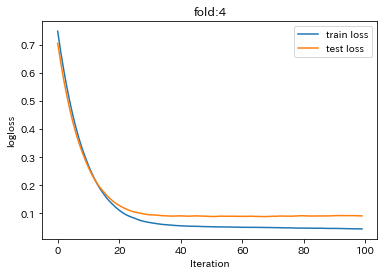

[I 2021-12-27 17:23:37,885] A new study created in memory with name: no-name-e6865d64-c673-429c-8aaf-5fd6fdd4e6f7


[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:38,099] Trial 0 finished with value: 0.10550872451209597 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.10550872451209597.


Early stopping, best iteration is:
[45]	Train's rmse: 0.137211	Test's rmse: 0.105509
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:38,304] Trial 1 finished with value: 0.11377610287415038 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.10550872451209597.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131441	Test's rmse: 0.113776
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:38,517] Trial 2 finished with value: 0.11244838345361713 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.10550872451209597.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130774	Test's rmse: 0.112448
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:38,749] Trial 3 finished with value: 0.11293419358997259 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.10550872451209597.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130269	Test's rmse: 0.112934
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:38,972] Trial 4 finished with value: 0.11114515874315459 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.10550872451209597.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132549	Test's rmse: 0.111145
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:39,196] Trial 5 finished with value: 0.11352264913354888 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.10550872451209597.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13041	Test's rmse: 0.113523
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:39,415] Trial 6 finished with value: 0.11352988393832612 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.10550872451209597.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130072	Test's rmse: 0.11353
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:39,857] Trial 7 finished with value: 0.10595579564039544 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.10595579564039544.


Early stopping, best iteration is:
[45]	Train's rmse: 0.137146	Test's rmse: 0.105956
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:40,751] Trial 8 finished with value: 0.10594697979407618 and parameters: {'num_leaves': 244}. Best is trial 8 with value: 0.10594697979407618.


Early stopping, best iteration is:
[45]	Train's rmse: 0.137147	Test's rmse: 0.105947
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:42,320] Trial 9 finished with value: 0.10594695557503195 and parameters: {'num_leaves': 188}. Best is trial 9 with value: 0.10594695557503195.


Early stopping, best iteration is:
[45]	Train's rmse: 0.137147	Test's rmse: 0.105947
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:43,774] Trial 10 finished with value: 0.10594685537367142 and parameters: {'num_leaves': 154}. Best is trial 10 with value: 0.10594685537367142.


Early stopping, best iteration is:
[45]	Train's rmse: 0.137148	Test's rmse: 0.105947
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:44,274] Trial 11 finished with value: 0.10593292723249768 and parameters: {'num_leaves': 41}. Best is trial 11 with value: 0.10593292723249768.


Early stopping, best iteration is:
[45]	Train's rmse: 0.137135	Test's rmse: 0.105933
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:44,779] Trial 12 finished with value: 0.10593292723249768 and parameters: {'num_leaves': 41}. Best is trial 11 with value: 0.10593292723249768.
[I 2021-12-27 17:23:44,948] Trial 13 finished with value: 0.10593402708963821 and parameters: {'num_leaves': 16}. Best is trial 11 with value: 0.10593292723249768.


Early stopping, best iteration is:
[45]	Train's rmse: 0.137135	Test's rmse: 0.105933
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	Train's rmse: 0.137184	Test's rmse: 0.105934
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:45,732] Trial 14 finished with value: 0.10594698621826083 and parameters: {'num_leaves': 222}. Best is trial 11 with value: 0.10593292723249768.


Early stopping, best iteration is:
[45]	Train's rmse: 0.137147	Test's rmse: 0.105947
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:46,850] Trial 15 finished with value: 0.10594688399494046 and parameters: {'num_leaves': 155}. Best is trial 11 with value: 0.10593292723249768.


Early stopping, best iteration is:
[45]	Train's rmse: 0.137148	Test's rmse: 0.105947
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:48,586] Trial 16 finished with value: 0.10594692960856832 and parameters: {'num_leaves': 182}. Best is trial 11 with value: 0.10593292723249768.


Early stopping, best iteration is:
[45]	Train's rmse: 0.137147	Test's rmse: 0.105947
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:49,414] Trial 17 finished with value: 0.1059475701493652 and parameters: {'num_leaves': 81}. Best is trial 11 with value: 0.10593292723249768.
[I 2021-12-27 17:23:49,524] Trial 18 finished with value: 0.1128230139089547 and parameters: {'num_leaves': 2}. Best is trial 11 with value: 0.10593292723249768.


Early stopping, best iteration is:
[45]	Train's rmse: 0.137148	Test's rmse: 0.105948
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142917	Test's rmse: 0.112823
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:50,101] Trial 19 finished with value: 0.10594621817022282 and parameters: {'num_leaves': 56}. Best is trial 11 with value: 0.10593292723249768.


Early stopping, best iteration is:
[45]	Train's rmse: 0.137135	Test's rmse: 0.105946
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:50,352] Trial 20 finished with value: 0.10593292723249768 and parameters: {'num_leaves': 41}. Best is trial 11 with value: 0.10593292723249768.


Early stopping, best iteration is:
[45]	Train's rmse: 0.137135	Test's rmse: 0.105933
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:50,792] Trial 21 finished with value: 0.10595639331775901 and parameters: {'num_leaves': 103}. Best is trial 11 with value: 0.10593292723249768.


Early stopping, best iteration is:
[45]	Train's rmse: 0.137146	Test's rmse: 0.105956
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:51,067] Trial 22 finished with value: 0.10547212550770621 and parameters: {'num_leaves': 46}. Best is trial 22 with value: 0.10547212550770621.


Early stopping, best iteration is:
[45]	Train's rmse: 0.137209	Test's rmse: 0.105472
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:51,642] Trial 23 finished with value: 0.11332653834906144 and parameters: {'num_leaves': 67}. Best is trial 22 with value: 0.10547212550770621.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131081	Test's rmse: 0.113327
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:52,757] Trial 24 finished with value: 0.10595543170979188 and parameters: {'num_leaves': 111}. Best is trial 22 with value: 0.10547212550770621.


Early stopping, best iteration is:
[45]	Train's rmse: 0.137146	Test's rmse: 0.105955
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:53,195] Trial 25 finished with value: 0.11205713064602264 and parameters: {'num_leaves': 26}. Best is trial 22 with value: 0.10547212550770621.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130904	Test's rmse: 0.112057
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:54,461] Trial 26 finished with value: 0.10594780004489815 and parameters: {'num_leaves': 131}. Best is trial 22 with value: 0.10547212550770621.


Early stopping, best iteration is:
[45]	Train's rmse: 0.137148	Test's rmse: 0.105948
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:55,070] Trial 27 finished with value: 0.14457814339203345 and parameters: {'bagging_fraction': 0.624724071308792, 'bagging_freq': 7}. Best is trial 27 with value: 0.14457814339203345.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168516	Test's rmse: 0.144578
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:55,472] Trial 28 finished with value: 0.1171779373284149 and parameters: {'bagging_fraction': 0.8391963650875751, 'bagging_freq': 5}. Best is trial 28 with value: 0.1171779373284149.


Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.142426	Test's rmse: 0.117178
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:55,776] Trial 29 finished with value: 0.1483967714723485 and parameters: {'bagging_fraction': 0.49361118426561795, 'bagging_freq': 2}. Best is trial 28 with value: 0.1171779373284149.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.180192	Test's rmse: 0.148397
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:56,068] Trial 30 finished with value: 0.14827565401083162 and parameters: {'bagging_fraction': 0.4348501673009778, 'bagging_freq': 7}. Best is trial 28 with value: 0.1171779373284149.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182766	Test's rmse: 0.148276
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:56,360] Trial 31 finished with value: 0.11629892699570725 and parameters: {'bagging_fraction': 0.7606690070465265, 'bagging_freq': 5}. Best is trial 31 with value: 0.11629892699570725.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148062	Test's rmse: 0.116299
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:56,945] Trial 32 finished with value: 0.14965472458288961 and parameters: {'bagging_fraction': 0.41235069657750206, 'bagging_freq': 7}. Best is trial 31 with value: 0.11629892699570725.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.184375	Test's rmse: 0.149655
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:57,530] Trial 33 finished with value: 0.10725187266409728 and parameters: {'bagging_fraction': 0.8994655844810855, 'bagging_freq': 2}. Best is trial 33 with value: 0.10725187266409728.


Early stopping, best iteration is:
[45]	Train's rmse: 0.139012	Test's rmse: 0.107252
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:58,125] Trial 34 finished with value: 0.14706295312174641 and parameters: {'bagging_fraction': 0.5090949803244422, 'bagging_freq': 2}. Best is trial 33 with value: 0.10725187266409728.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.177549	Test's rmse: 0.147063
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:58,734] Trial 35 finished with value: 0.14340455766737042 and parameters: {'bagging_fraction': 0.5825453457760269, 'bagging_freq': 4}. Best is trial 33 with value: 0.10725187266409728.


Did not meet early stopping. Best iteration is:
[92]	Train's rmse: 0.169785	Test's rmse: 0.143405
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:23:59,360] Trial 36 finished with value: 0.1370967835371503 and parameters: {'bagging_fraction': 0.6591670111857015, 'bagging_freq': 3}. Best is trial 33 with value: 0.10725187266409728.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.16627	Test's rmse: 0.137097
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:00,131] Trial 37 finished with value: 0.10547212550770621 and parameters: {'feature_fraction': 0.552}. Best is trial 37 with value: 0.10547212550770621.


Early stopping, best iteration is:
[45]	Train's rmse: 0.137209	Test's rmse: 0.105472
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:00,607] Trial 38 finished with value: 0.10547212550770621 and parameters: {'feature_fraction': 0.584}. Best is trial 37 with value: 0.10547212550770621.


Early stopping, best iteration is:
[45]	Train's rmse: 0.137209	Test's rmse: 0.105472
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:00,930] Trial 39 finished with value: 0.11192555200662686 and parameters: {'feature_fraction': 0.6799999999999999}. Best is trial 37 with value: 0.10547212550770621.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130828	Test's rmse: 0.111926
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:01,191] Trial 40 finished with value: 0.10547212550770621 and parameters: {'feature_fraction': 0.6479999999999999}. Best is trial 37 with value: 0.10547212550770621.


Early stopping, best iteration is:
[45]	Train's rmse: 0.137209	Test's rmse: 0.105472
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:01,471] Trial 41 finished with value: 0.11275084860999293 and parameters: {'feature_fraction': 0.52}. Best is trial 37 with value: 0.10547212550770621.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131301	Test's rmse: 0.112751
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:01,846] Trial 42 finished with value: 0.10547212550770621 and parameters: {'feature_fraction': 0.616}. Best is trial 37 with value: 0.10547212550770621.


Early stopping, best iteration is:
[45]	Train's rmse: 0.137209	Test's rmse: 0.105472
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2021-12-27 17:24:02,409] Trial 43 finished with value: 0.1090312741753738 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403}. Best is trial 43 with value: 0.1090312741753738.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132292	Test's rmse: 0.109031
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2021-12-27 17:24:02,947] Trial 44 finished with value: 0.11275072278254468 and parameters: {'lambda_l1': 0.038720902953704193, 'lambda_l2': 0.0024430162614261413}. Best is trial 43 with value: 0.1090312741753738.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 17:24:03,509] Trial 45 finished with value: 0.10547212553585483 and parameters: {'lambda_l1': 2.5361081166471375e-07, 'lambda_l2': 2.5348407664333426e-07}. Best is trial 45 with value: 0.10547212553585483.


Early stopping, best iteration is:
[45]	Train's rmse: 0.137209	Test's rmse: 0.105472
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:04,119] Trial 46 finished with value: 0.11253478217856995 and parameters: {'lambda_l1': 3.3323645788192616e-08, 'lambda_l2': 0.6245760287469893}. Best is trial 45 with value: 0.10547212553585483.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131	Test's rmse: 0.112535
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:04,729] Trial 47 finished with value: 0.10557543657709353 and parameters: {'lambda_l1': 0.002570603566117598, 'lambda_l2': 0.023585940584142682}. Best is trial 45 with value: 0.10547212553585483.


Early stopping, best iteration is:
[45]	Train's rmse: 0.137234	Test's rmse: 0.105575
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2021-12-27 17:24:05,318] Trial 48 finished with value: 0.10734322539778364 and parameters: {'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285}. Best is trial 45 with value: 0.10547212553585483.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133443	Test's rmse: 0.107343
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2021-12-27 17:24:05,661] Trial 49 finished with value: 0.10541499537382425 and parameters: {'lambda_l1': 0.31044435499483225, 'lambda_l2': 8.148018307012941e-07}. Best is trial 49 with value: 0.10541499537382425.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 17:24:05,970] Trial 50 finished with value: 0.10547212570423253 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07}. Best is trial 49 with value: 0.10541499537382425.


Early stopping, best iteration is:
[45]	Train's rmse: 0.137209	Test's rmse: 0.105472
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:06,263] Trial 51 finished with value: 0.10601266302391675 and parameters: {'lambda_l1': 5.472429642032198e-06, 'lambda_l2': 0.00052821153945323}. Best is trial 49 with value: 0.10541499537382425.


Early stopping, best iteration is:
[45]	Train's rmse: 0.137151	Test's rmse: 0.106013
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:06,593] Trial 52 finished with value: 0.11305281398297015 and parameters: {'lambda_l1': 7.71800699380605e-05, 'lambda_l2': 4.17890272377219e-06}. Best is trial 49 with value: 0.10541499537382425.
[I 2021-12-27 17:24:06,745] Trial 53 finished with value: 0.10792386775253125 and parameters: {'lambda_l1': 6.338181430721368, 'lambda_l2': 1.1323342574941946e-08}. Best is trial 49 with value: 0.10541499537382425.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131167	Test's rmse: 0.113053
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2021-12-27 17:24:06,915] Trial 54 finished with value: 0.10629757925790335 and parameters: {'lambda_l1': 0.8882233476138306, 'lambda_l2': 3.8146497538118136e-06}. Best is trial 49 with value: 0.10541499537382425.


[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

[I 2021-12-27 17:24:07,265] Trial 55 finished with value: 0.1126941232535046 and parameters: {'lambda_l1': 0.005764962972197511, 'lambda_l2': 2.2311398834761413e-08}. Best is trial 49 with value: 0.10541499537382425.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131008	Test's rmse: 0.112694
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2021-12-27 17:24:07,913] Trial 56 finished with value: 0.11127880435192662 and parameters: {'lambda_l1': 0.15412667882547773, 'lambda_l2': 8.476957030644476e-06}. Best is trial 49 with value: 0.10541499537382425.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 17:24:08,595] Trial 57 finished with value: 0.10595405740770322 and parameters: {'lambda_l1': 0.0008472745658933207, 'lambda_l2': 3.8099063671275144e-07}. Best is trial 49 with value: 0.10541499537382425.


Early stopping, best iteration is:
[45]	Train's rmse: 0.137142	Test's rmse: 0.105954
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:08,951] Trial 58 finished with value: 0.10550643491742417 and parameters: {'lambda_l1': 1.0588847274499866e-06, 'lambda_l2': 4.624083095518924e-05}. Best is trial 49 with value: 0.10541499537382425.


Early stopping, best iteration is:
[45]	Train's rmse: 0.137224	Test's rmse: 0.105506
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:09,312] Trial 59 finished with value: 0.11213972021837675 and parameters: {'lambda_l1': 0.00023072438437673793, 'lambda_l2': 1.6256734488702318e-07}. Best is trial 49 with value: 0.10541499537382425.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131071	Test's rmse: 0.11214
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:10,302] Trial 60 finished with value: 0.11305128920344684 and parameters: {'lambda_l1': 1.8796187625037182e-07, 'lambda_l2': 0.00012458442378798088}. Best is trial 49 with value: 0.10541499537382425.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131027	Test's rmse: 0.113051
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2021-12-27 17:24:10,520] Trial 61 finished with value: 0.10830011604197268 and parameters: {'lambda_l1': 8.165732042052507, 'lambda_l2': 8.530608697375435e-08}. Best is trial 49 with value: 0.10541499537382425.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 17:24:10,808] Trial 62 finished with value: 0.11266341490331541 and parameters: {'lambda_l1': 0.06650281713801058, 'lambda_l2': 8.498547779430878e-07}. Best is trial 49 with value: 0.10541499537382425.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 17:24:10,994] Trial 63 finished with value: 0.18551638927918118 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.18551638927918118.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 17:24:11,172] Trial 64 finished with value: 0.24109817811041567 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.18551638927918118.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 17:24:11,368] Trial 65 finished with value: 0.12482443616281305 and parameters: {'min_child_samples': 25}. Best is trial 65 with value: 0.12482443616281305.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 17:24:11,848] Trial 66 finished with value: 0.06993042616175904 and parameters: {'min_child_samples': 10}. Best is trial 66 with value: 0.06993042616175904.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0841721	Test's rmse: 0.0699304
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369880
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2021-12-27 17:24:12,342] Trial 67 finished with value: 0.034925285626102746 and parameters: {'min_child_samples': 5}. Best is trial 67 with value: 0.034925285626102746.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

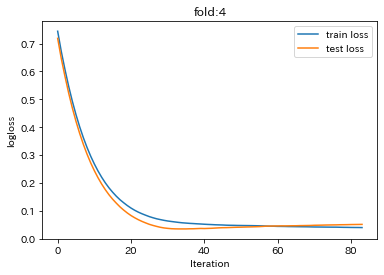

[I 2021-12-27 17:24:12,514] A new study created in memory with name: no-name-3d96309f-d373-492d-b581-790959d363a2


[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:12,776] Trial 0 finished with value: 0.21171338614010762 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.21171338614010762.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0963473	Test's rmse: 0.211713
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:13,008] Trial 1 finished with value: 0.2111841400013152 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 0.2111841400013152.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0961626	Test's rmse: 0.211184
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:13,218] Trial 2 finished with value: 0.2149446561282099 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 0.2111841400013152.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0993086	Test's rmse: 0.214945
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:13,812] Trial 3 finished with value: 0.21129767729525134 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 0.2111841400013152.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0964829	Test's rmse: 0.211298
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:14,172] Trial 4 finished with value: 0.21094774229856658 and parameters: {'feature_fraction': 0.8}. Best is trial 4 with value: 0.21094774229856658.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.096181	Test's rmse: 0.210948
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:14,436] Trial 5 finished with value: 0.21106935026874796 and parameters: {'feature_fraction': 0.6}. Best is trial 4 with value: 0.21094774229856658.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.096483	Test's rmse: 0.211069
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:14,646] Trial 6 finished with value: 0.21126069606722267 and parameters: {'feature_fraction': 0.5}. Best is trial 4 with value: 0.21094774229856658.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.097063	Test's rmse: 0.211261
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:15,334] Trial 7 finished with value: 0.2108465761632132 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.2108465761632132.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0957904	Test's rmse: 0.210847
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 17:24:16,825] Trial 8 finished with value: 0.21142041301013514 and parameters: {'num_leaves': 244}. Best is trial 7 with value: 0.2108465761632132.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0959942	Test's rmse: 0.21142
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:17,858] Trial 9 finished with value: 0.21147755083852984 and parameters: {'num_leaves': 188}. Best is trial 7 with value: 0.2108465761632132.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0959369	Test's rmse: 0.211478
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:18,763] Trial 10 finished with value: 0.211533247196825 and parameters: {'num_leaves': 154}. Best is trial 7 with value: 0.2108465761632132.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0961499	Test's rmse: 0.211533
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:19,000] Trial 11 finished with value: 0.21132170568816247 and parameters: {'num_leaves': 41}. Best is trial 7 with value: 0.2108465761632132.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0957484	Test's rmse: 0.211322
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:19,265] Trial 12 finished with value: 0.21132170568816247 and parameters: {'num_leaves': 41}. Best is trial 7 with value: 0.2108465761632132.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0957484	Test's rmse: 0.211322
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:19,462] Trial 13 finished with value: 0.21190814874971564 and parameters: {'num_leaves': 16}. Best is trial 7 with value: 0.2108465761632132.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0962824	Test's rmse: 0.211908
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 17:24:20,524] Trial 14 finished with value: 0.211658192777166 and parameters: {'num_leaves': 222}. Best is trial 7 with value: 0.2108465761632132.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0961757	Test's rmse: 0.211658
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:21,442] Trial 15 finished with value: 0.2114775973333597 and parameters: {'num_leaves': 155}. Best is trial 7 with value: 0.2108465761632132.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0959369	Test's rmse: 0.211478
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:22,412] Trial 16 finished with value: 0.2115378420753339 and parameters: {'num_leaves': 182}. Best is trial 7 with value: 0.2108465761632132.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0961495	Test's rmse: 0.211538
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:23,033] Trial 17 finished with value: 0.2108465761632132 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.2108465761632132.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0957904	Test's rmse: 0.210847
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:23,499] Trial 18 finished with value: 0.21084222846395825 and parameters: {'num_leaves': 98}. Best is trial 18 with value: 0.21084222846395825.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0957856	Test's rmse: 0.210842
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:23,960] Trial 19 finished with value: 0.21124746243678608 and parameters: {'num_leaves': 92}. Best is trial 18 with value: 0.21084222846395825.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0962103	Test's rmse: 0.211247
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:24,448] Trial 20 finished with value: 0.21128771245008499 and parameters: {'num_leaves': 104}. Best is trial 18 with value: 0.21084222846395825.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0961149	Test's rmse: 0.211288
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:24,811] Trial 21 finished with value: 0.2112523979687307 and parameters: {'num_leaves': 69}. Best is trial 18 with value: 0.21084222846395825.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0959929	Test's rmse: 0.211252
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:25,389] Trial 22 finished with value: 0.2118714124044551 and parameters: {'num_leaves': 125}. Best is trial 18 with value: 0.21084222846395825.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0961136	Test's rmse: 0.211871
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:25,759] Trial 23 finished with value: 0.21082825321347118 and parameters: {'num_leaves': 67}. Best is trial 23 with value: 0.21082825321347118.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0959788	Test's rmse: 0.210828
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:26,122] Trial 24 finished with value: 0.21095600270200898 and parameters: {'num_leaves': 64}. Best is trial 23 with value: 0.21082825321347118.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0959733	Test's rmse: 0.210956
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:26,310] Trial 25 finished with value: 0.2119557720447259 and parameters: {'num_leaves': 23}. Best is trial 23 with value: 0.21082825321347118.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0962345	Test's rmse: 0.211956
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:26,654] Trial 26 finished with value: 0.21120475402216457 and parameters: {'num_leaves': 61}. Best is trial 23 with value: 0.21082825321347118.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0962433	Test's rmse: 0.211205
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:27,029] Trial 27 finished with value: 0.2623682824599623 and parameters: {'bagging_fraction': 0.624724071308792, 'bagging_freq': 7}. Best is trial 27 with value: 0.2623682824599623.


Early stopping, best iteration is:
[49]	Train's rmse: 0.139925	Test's rmse: 0.262368
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:27,427] Trial 28 finished with value: 0.2280230081621901 and parameters: {'bagging_fraction': 0.8391963650875751, 'bagging_freq': 5}. Best is trial 28 with value: 0.2280230081621901.


Did not meet early stopping. Best iteration is:
[95]	Train's rmse: 0.109022	Test's rmse: 0.228023
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:27,813] Trial 29 finished with value: 0.2779998933680606 and parameters: {'bagging_fraction': 0.49361118426561795, 'bagging_freq': 2}. Best is trial 28 with value: 0.2280230081621901.


Did not meet early stopping. Best iteration is:
[88]	Train's rmse: 0.144354	Test's rmse: 0.278
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:28,214] Trial 30 finished with value: 0.2962298903400786 and parameters: {'bagging_fraction': 0.4348501673009778, 'bagging_freq': 7}. Best is trial 28 with value: 0.2280230081621901.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.157645	Test's rmse: 0.29623
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:28,643] Trial 31 finished with value: 0.24542055356261583 and parameters: {'bagging_fraction': 0.7606690070465265, 'bagging_freq': 5}. Best is trial 28 with value: 0.2280230081621901.


Did not meet early stopping. Best iteration is:
[96]	Train's rmse: 0.119815	Test's rmse: 0.245421
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:29,038] Trial 32 finished with value: 0.29487975199482874 and parameters: {'bagging_fraction': 0.41235069657750206, 'bagging_freq': 7}. Best is trial 28 with value: 0.2280230081621901.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.158909	Test's rmse: 0.29488
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:29,476] Trial 33 finished with value: 0.21606673809527857 and parameters: {'bagging_fraction': 0.8994655844810855, 'bagging_freq': 2}. Best is trial 33 with value: 0.21606673809527857.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.102073	Test's rmse: 0.216067
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:29,873] Trial 34 finished with value: 0.2698367014970938 and parameters: {'bagging_fraction': 0.5090949803244422, 'bagging_freq': 2}. Best is trial 33 with value: 0.21606673809527857.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.143582	Test's rmse: 0.269837
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:30,243] Trial 35 finished with value: 0.26664013832005806 and parameters: {'bagging_fraction': 0.5825453457760269, 'bagging_freq': 4}. Best is trial 33 with value: 0.21606673809527857.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141259	Test's rmse: 0.26664
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:30,633] Trial 36 finished with value: 0.2610722365951676 and parameters: {'bagging_fraction': 0.6591670111857015, 'bagging_freq': 3}. Best is trial 33 with value: 0.21606673809527857.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.124197	Test's rmse: 0.261072
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:30,995] Trial 37 finished with value: 0.21082825321347118 and parameters: {'feature_fraction': 0.784}. Best is trial 37 with value: 0.21082825321347118.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0959788	Test's rmse: 0.210828
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:31,368] Trial 38 finished with value: 0.21082825321347118 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 37 with value: 0.21082825321347118.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0959788	Test's rmse: 0.210828
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:31,736] Trial 39 finished with value: 0.21082825321347118 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 37 with value: 0.21082825321347118.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0959788	Test's rmse: 0.210828
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:32,101] Trial 40 finished with value: 0.21082825321347118 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 37 with value: 0.21082825321347118.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0959788	Test's rmse: 0.210828
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:32,448] Trial 41 finished with value: 0.2109378498799278 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 37 with value: 0.21082825321347118.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0969562	Test's rmse: 0.210938
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:32,807] Trial 42 finished with value: 0.21115795000904952 and parameters: {'feature_fraction': 0.88}. Best is trial 37 with value: 0.21082825321347118.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0960523	Test's rmse: 0.211158
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2021-12-27 17:24:33,135] Trial 43 finished with value: 0.2104150073027423 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403}. Best is trial 43 with value: 0.2104150073027423.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0970757	Test's rmse: 0.210415
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2021-12-27 17:24:33,392] Trial 44 finished with value: 0.21124665535672038 and parameters: {'lambda_l1': 0.038720902953704193, 'lambda_l2': 0.0024430162614261413}. Best is trial 43 with value: 0.2104150073027423.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 17:24:33,756] Trial 45 finished with value: 0.21082825366615018 and parameters: {'lambda_l1': 2.5361081166471375e-07, 'lambda_l2': 2.5348407664333426e-07}. Best is trial 43 with value: 0.2104150073027423.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0959788	Test's rmse: 0.210828
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2021-12-27 17:24:34,158] Trial 46 finished with value: 0.21117098767293313 and parameters: {'lambda_l1': 3.3323645788192616e-08, 'lambda_l2': 0.6245760287469893}. Best is trial 43 with value: 0.2104150073027423.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.096148	Test's rmse: 0.211171
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2021-12-27 17:24:34,553] Trial 47 finished with value: 0.2114041721286684 and parameters: {'lambda_l1': 0.002570603566117598, 'lambda_l2': 0.023585940584142682}. Best is trial 43 with value: 0.2104150073027423.


[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

[I 2021-12-27 17:24:34,903] Trial 48 finished with value: 0.21135736412531347 and parameters: {'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285}. Best is trial 43 with value: 0.2104150073027423.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0977916	Test's rmse: 0.211357
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2021-12-27 17:24:35,103] Trial 49 finished with value: 0.2120903252453851 and parameters: {'lambda_l1': 0.31044435499483225, 'lambda_l2': 8.148018307012941e-07}. Best is trial 43 with value: 0.2104150073027423.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 17:24:35,501] Trial 50 finished with value: 0.21071876167477624 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07}. Best is trial 43 with value: 0.2104150073027423.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0959486	Test's rmse: 0.210719
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:35,907] Trial 51 finished with value: 0.21124842409541172 and parameters: {'lambda_l1': 5.472429642032198e-06, 'lambda_l2': 0.00052821153945323}. Best is trial 43 with value: 0.2104150073027423.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0956666	Test's rmse: 0.211248
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:36,319] Trial 52 finished with value: 0.21089512373300262 and parameters: {'lambda_l1': 7.71800699380605e-05, 'lambda_l2': 4.17890272377219e-06}. Best is trial 43 with value: 0.2104150073027423.
[I 2021-12-27 17:24:36,486] Trial 53 finished with value: 0.21429002527961402 and parameters: {'lambda_l1': 3.207959657544482, 'lambda_l2': 0.08759673038878969}. Best is trial 43 with value: 0.2104150073027423.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.09572	Test's rmse: 0.210895
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2021-12-27 17:24:36,917] Trial 54 finished with value: 0.21145930084283768 and parameters: {'lambda_l1': 4.821395295002391e-06, 'lambda_l2': 1.2561511227172681e-08}. Best is trial 43 with value: 0.2104150073027423.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.095619	Test's rmse: 0.211459
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:37,287] Trial 55 finished with value: 0.21116122447912025 and parameters: {'lambda_l1': 8.929727759263381e-05, 'lambda_l2': 1.2471308694521838e-05}. Best is trial 43 with value: 0.2104150073027423.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0958394	Test's rmse: 0.211161
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:37,653] Trial 56 finished with value: 0.211459340013447 and parameters: {'lambda_l1': 1.990632676927375e-06, 'lambda_l2': 5.549852832146232e-05}. Best is trial 43 with value: 0.2104150073027423.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.095619	Test's rmse: 0.211459
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:38,018] Trial 57 finished with value: 0.21116268343942807 and parameters: {'lambda_l1': 0.0013643656722816411, 'lambda_l2': 1.169492507195757e-08}. Best is trial 43 with value: 0.2104150073027423.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0962641	Test's rmse: 0.211163
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:38,386] Trial 58 finished with value: 0.21115403150447593 and parameters: {'lambda_l1': 3.4085055624960927e-07, 'lambda_l2': 0.006102809359460511}. Best is trial 43 with value: 0.2104150073027423.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0958445	Test's rmse: 0.211154
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2021-12-27 17:24:38,715] Trial 59 finished with value: 0.21217355677176808 and parameters: {'lambda_l1': 2.8949041243074206e-05, 'lambda_l2': 8.462570930314385}. Best is trial 43 with value: 0.2104150073027423.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0982952	Test's rmse: 0.212174
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:39,098] Trial 60 finished with value: 0.21145935815285044 and parameters: {'lambda_l1': 2.1401082380677553e-07, 'lambda_l2': 0.0001499492580537855}. Best is trial 43 with value: 0.2104150073027423.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.095619	Test's rmse: 0.211459
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:39,457] Trial 61 finished with value: 0.21071916618195963 and parameters: {'lambda_l1': 0.0014441715954420051, 'lambda_l2': 1.9647872177103516e-07}. Best is trial 43 with value: 0.2104150073027423.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0962773	Test's rmse: 0.210719
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2021-12-27 17:24:39,840] Trial 62 finished with value: 0.21100542578996848 and parameters: {'lambda_l1': 1.353150818771601e-05, 'lambda_l2': 0.3878957543086852}. Best is trial 43 with value: 0.2104150073027423.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0957488	Test's rmse: 0.211005
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2021-12-27 17:24:40,172] Trial 63 finished with value: 0.3670002606018655 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.3670002606018655.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 17:24:40,540] Trial 64 finished with value: 0.17170065670841017 and parameters: {'min_child_samples': 10}. Best is trial 64 with value: 0.17170065670841017.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0574316	Test's rmse: 0.171701
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2021-12-27 17:24:40,884] Trial 65 finished with value: 0.32582633008095885 and parameters: {'min_child_samples': 50}. Best is trial 64 with value: 0.17170065670841017.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.176671	Test's rmse: 0.325826
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2021-12-27 17:24:41,263] Trial 66 finished with value: 0.11912272386321471 and parameters: {'min_child_samples': 5}. Best is trial 66 with value: 0.11912272386321471.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0208997	Test's rmse: 0.119123
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.367620
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2021-12-27 17:24:41,631] Trial 67 finished with value: 0.2448318026395867 and parameters: {'min_child_samples': 25}. Best is trial 66 with value: 0.11912272386321471.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119516	Test's rmse: 0.244832


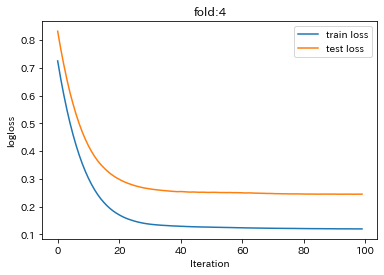

[I 2021-12-27 17:24:41,836] A new study created in memory with name: no-name-c4e8ef3f-2043-43b3-9f47-71f23e36e47e
[I 2021-12-27 17:24:42,022] Trial 0 finished with value: 0.09256972271698699 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.09256972271698699.


[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	Train's rmse: 0.144523	Test's rmse: 0.0925697
[LightGBM] [Info] Total Bins 2052


[I 2021-12-27 17:24:42,206] Trial 1 finished with value: 0.09164731270527784 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 0.09164731270527784.


[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	Train's rmse: 0.145157	Test's rmse: 0.0916473
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566


[I 2021-12-27 17:24:42,366] Trial 2 finished with value: 0.09270925785539871 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 0.09164731270527784.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	Train's rmse: 0.144496	Test's rmse: 0.0927093
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:42,545] Trial 3 finished with value: 0.0897698732416746 and parameters: {'feature_fraction': 0.5}. Best is trial 3 with value: 0.0897698732416746.
[I 2021-12-27 17:24:42,706] Trial 4 finished with value: 0.09112560219184986 and parameters: {'feature_fraction': 0.4}. Best is trial 3 with value: 0.0897698732416746.


Early stopping, best iteration is:
[33]	Train's rmse: 0.141646	Test's rmse: 0.0897699
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	Train's rmse: 0.143481	Test's rmse: 0.0911256
[LightGBM] [Info] Total Bins 2052


[I 2021-12-27 17:24:42,870] Trial 5 finished with value: 0.09162753366834807 and parameters: {'feature_fraction': 0.7}. Best is trial 3 with value: 0.0897698732416746.


[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	Train's rmse: 0.145171	Test's rmse: 0.0916275
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:43,055] Trial 6 finished with value: 0.09108268708387701 and parameters: {'feature_fraction': 0.6}. Best is trial 3 with value: 0.0897698732416746.


Early stopping, best iteration is:
[33]	Train's rmse: 0.139692	Test's rmse: 0.0910827
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:43,434] Trial 7 finished with value: 0.08987499750297144 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.08987499750297144.


Early stopping, best iteration is:
[33]	Train's rmse: 0.141617	Test's rmse: 0.089875
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:44,193] Trial 8 finished with value: 0.0898746043920232 and parameters: {'num_leaves': 244}. Best is trial 8 with value: 0.0898746043920232.


Early stopping, best iteration is:
[33]	Train's rmse: 0.141615	Test's rmse: 0.0898746
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:44,787] Trial 9 finished with value: 0.08987488328825467 and parameters: {'num_leaves': 188}. Best is trial 8 with value: 0.0898746043920232.


Early stopping, best iteration is:
[33]	Train's rmse: 0.141616	Test's rmse: 0.0898749
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:45,318] Trial 10 finished with value: 0.08987733828412112 and parameters: {'num_leaves': 154}. Best is trial 8 with value: 0.0898746043920232.


Early stopping, best iteration is:
[33]	Train's rmse: 0.141616	Test's rmse: 0.0898773
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:45,537] Trial 11 finished with value: 0.0899016334366496 and parameters: {'num_leaves': 41}. Best is trial 8 with value: 0.0898746043920232.


Early stopping, best iteration is:
[33]	Train's rmse: 0.14165	Test's rmse: 0.0899016
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:45,806] Trial 12 finished with value: 0.0899016334366496 and parameters: {'num_leaves': 41}. Best is trial 8 with value: 0.0898746043920232.
[I 2021-12-27 17:24:45,913] Trial 13 finished with value: 0.09016795108360534 and parameters: {'num_leaves': 16}. Best is trial 8 with value: 0.0898746043920232.


Early stopping, best iteration is:
[33]	Train's rmse: 0.14165	Test's rmse: 0.0899016
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	Train's rmse: 0.141692	Test's rmse: 0.090168
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:46,479] Trial 14 finished with value: 0.08987473740033972 and parameters: {'num_leaves': 222}. Best is trial 8 with value: 0.0898746043920232.


Early stopping, best iteration is:
[33]	Train's rmse: 0.141615	Test's rmse: 0.0898747
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:46,886] Trial 15 finished with value: 0.08987719431516061 and parameters: {'num_leaves': 155}. Best is trial 8 with value: 0.0898746043920232.


Early stopping, best iteration is:
[33]	Train's rmse: 0.141616	Test's rmse: 0.0898772
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:47,414] Trial 16 finished with value: 0.0898755566252289 and parameters: {'num_leaves': 182}. Best is trial 8 with value: 0.0898746043920232.


Early stopping, best iteration is:
[33]	Train's rmse: 0.141616	Test's rmse: 0.0898756
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:48,236] Trial 17 finished with value: 0.08987418824157341 and parameters: {'num_leaves': 251}. Best is trial 17 with value: 0.08987418824157341.


Early stopping, best iteration is:
[33]	Train's rmse: 0.141615	Test's rmse: 0.0898742
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:49,004] Trial 18 finished with value: 0.08987422803365966 and parameters: {'num_leaves': 239}. Best is trial 17 with value: 0.08987418824157341.


Early stopping, best iteration is:
[33]	Train's rmse: 0.141615	Test's rmse: 0.0898742
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:49,817] Trial 19 finished with value: 0.0898741363270286 and parameters: {'num_leaves': 252}. Best is trial 19 with value: 0.0898741363270286.


Early stopping, best iteration is:
[33]	Train's rmse: 0.141615	Test's rmse: 0.0898741
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:50,532] Trial 20 finished with value: 0.08987591813799199 and parameters: {'num_leaves': 209}. Best is trial 19 with value: 0.0898741363270286.


Early stopping, best iteration is:
[33]	Train's rmse: 0.141615	Test's rmse: 0.0898759
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:51,334] Trial 21 finished with value: 0.0898741363270286 and parameters: {'num_leaves': 252}. Best is trial 19 with value: 0.0898741363270286.


Early stopping, best iteration is:
[33]	Train's rmse: 0.141615	Test's rmse: 0.0898741
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:51,742] Trial 22 finished with value: 0.08987675409845945 and parameters: {'num_leaves': 89}. Best is trial 19 with value: 0.0898741363270286.


Early stopping, best iteration is:
[33]	Train's rmse: 0.141617	Test's rmse: 0.0898768
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:52,265] Trial 23 finished with value: 0.08987529119982872 and parameters: {'num_leaves': 196}. Best is trial 19 with value: 0.0898741363270286.


Early stopping, best iteration is:
[33]	Train's rmse: 0.141616	Test's rmse: 0.0898753
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:52,649] Trial 24 finished with value: 0.08987681311594638 and parameters: {'num_leaves': 138}. Best is trial 19 with value: 0.0898741363270286.


Early stopping, best iteration is:
[33]	Train's rmse: 0.141616	Test's rmse: 0.0898768
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:53,338] Trial 25 finished with value: 0.08987509585525524 and parameters: {'num_leaves': 220}. Best is trial 19 with value: 0.0898741363270286.


Early stopping, best iteration is:
[33]	Train's rmse: 0.141615	Test's rmse: 0.0898751
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:54,122] Trial 26 finished with value: 0.08987400830126784 and parameters: {'num_leaves': 256}. Best is trial 26 with value: 0.08987400830126784.


Early stopping, best iteration is:
[33]	Train's rmse: 0.141615	Test's rmse: 0.089874
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	Train's rmse: 0.158624	Test's rmse: 0.130395


[I 2021-12-27 17:24:54,308] Trial 27 finished with value: 0.13039470317544682 and parameters: {'bagging_fraction': 0.624724071308792, 'bagging_freq': 7}. Best is trial 27 with value: 0.13039470317544682.
[I 2021-12-27 17:24:54,458] Trial 28 finished with value: 0.09042509747633248 and parameters: {'bagging_fraction': 0.8391963650875751, 'bagging_freq': 5}. Best is trial 28 with value: 0.09042509747633248.


[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	Train's rmse: 0.142096	Test's rmse: 0.0904251
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:54,625] Trial 29 finished with value: 0.15238511831224172 and parameters: {'bagging_fraction': 0.49361118426561795, 'bagging_freq': 2}. Best is trial 28 with value: 0.09042509747633248.
[I 2021-12-27 17:24:54,792] Trial 30 finished with value: 0.15106216264848957 and parameters: {'bagging_fraction': 0.4348501673009778, 'bagging_freq': 7}. Best is trial 28 with value: 0.09042509747633248.


Early stopping, best iteration is:
[36]	Train's rmse: 0.202795	Test's rmse: 0.152385
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	Train's rmse: 0.218667	Test's rmse: 0.151062
[LightGBM] [Info] Total Bins 2052


[I 2021-12-27 17:24:54,941] Trial 31 finished with value: 0.1042440116554048 and parameters: {'bagging_fraction': 0.7606690070465265, 'bagging_freq': 5}. Best is trial 28 with value: 0.09042509747633248.


[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	Train's rmse: 0.155809	Test's rmse: 0.104244
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:55,103] Trial 32 finished with value: 0.1544704803810658 and parameters: {'bagging_fraction': 0.41235069657750206, 'bagging_freq': 7}. Best is trial 28 with value: 0.09042509747633248.
[I 2021-12-27 17:24:55,262] Trial 33 finished with value: 0.09088088638959041 and parameters: {'bagging_fraction': 0.8994655844810855, 'bagging_freq': 2}. Best is trial 28 with value: 0.09042509747633248.


Early stopping, best iteration is:
[42]	Train's rmse: 0.221537	Test's rmse: 0.15447
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	Train's rmse: 0.144321	Test's rmse: 0.0908809
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566


[I 2021-12-27 17:24:55,408] Trial 34 finished with value: 0.1492138523279227 and parameters: {'bagging_fraction': 0.5090949803244422, 'bagging_freq': 2}. Best is trial 28 with value: 0.09042509747633248.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	Train's rmse: 0.205022	Test's rmse: 0.149214
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:55,586] Trial 35 finished with value: 0.1402416094647623 and parameters: {'bagging_fraction': 0.5825453457760269, 'bagging_freq': 4}. Best is trial 28 with value: 0.09042509747633248.
[I 2021-12-27 17:24:55,721] Trial 36 finished with value: 0.13052692152027484 and parameters: {'bagging_fraction': 0.6591670111857015, 'bagging_freq': 3}. Best is trial 28 with value: 0.09042509747633248.


Early stopping, best iteration is:
[40]	Train's rmse: 0.180159	Test's rmse: 0.140242
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	Train's rmse: 0.171536	Test's rmse: 0.130527
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566


[I 2021-12-27 17:24:55,884] Trial 37 finished with value: 0.0897698732416746 and parameters: {'feature_fraction': 0.5479999999999999}. Best is trial 37 with value: 0.0897698732416746.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	Train's rmse: 0.141646	Test's rmse: 0.0897699
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:56,029] Trial 38 finished with value: 0.09108268708387701 and parameters: {'feature_fraction': 0.58}. Best is trial 37 with value: 0.0897698732416746.
[I 2021-12-27 17:24:56,166] Trial 39 finished with value: 0.09112560219184986 and parameters: {'feature_fraction': 0.42}. Best is trial 37 with value: 0.0897698732416746.


Early stopping, best iteration is:
[33]	Train's rmse: 0.139692	Test's rmse: 0.0910827
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	Train's rmse: 0.143481	Test's rmse: 0.0911256
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566


[I 2021-12-27 17:24:56,311] Trial 40 finished with value: 0.0897698732416746 and parameters: {'feature_fraction': 0.516}. Best is trial 37 with value: 0.0897698732416746.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	Train's rmse: 0.141646	Test's rmse: 0.0897699
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:56,451] Trial 41 finished with value: 0.0897698732416746 and parameters: {'feature_fraction': 0.484}. Best is trial 37 with value: 0.0897698732416746.
[I 2021-12-27 17:24:56,588] Trial 42 finished with value: 0.0897698732416746 and parameters: {'feature_fraction': 0.45199999999999996}. Best is trial 37 with value: 0.0897698732416746.


Early stopping, best iteration is:
[33]	Train's rmse: 0.141646	Test's rmse: 0.0897699
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	Train's rmse: 0.141646	Test's rmse: 0.0897699
[LightGBM] [Info] Total Bins 2052


[I 2021-12-27 17:24:56,772] Trial 43 finished with value: 0.08883608897049287 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403}. Best is trial 43 with value: 0.08883608897049287.


[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	Train's rmse: 0.142676	Test's rmse: 0.0888361
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:56,912] Trial 44 finished with value: 0.08984597743233044 and parameters: {'lambda_l1': 0.038720902953704193, 'lambda_l2': 0.0024430162614261413}. Best is trial 43 with value: 0.08883608897049287.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 17:24:57,068] Trial 45 finished with value: 0.08976987341962557 and parameters: {'lambda_l1': 2.5361081166471375e-07, 'lambda_l2': 2.5348407664333426e-07}. Best is trial 43 with value: 0.08883608897049287.
[I 2021-12-27 17:24:57,229] Trial 46 finished with value: 0.08859618502623846 and parameters: {'lambda_l1': 3.3323645788192616e-08, 'lambda_l2': 0.6245760287469893}. Best is trial 46 with value: 0.08859618502623846.


Early stopping, best iteration is:
[33]	Train's rmse: 0.141646	Test's rmse: 0.0897699
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	Train's rmse: 0.142595	Test's rmse: 0.0885962
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566


[I 2021-12-27 17:24:57,373] Trial 47 finished with value: 0.08980548091184615 and parameters: {'lambda_l1': 0.002570603566117598, 'lambda_l2': 0.023585940584142682}. Best is trial 46 with value: 0.08859618502623846.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	Train's rmse: 0.14166	Test's rmse: 0.0898055
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

[I 2021-12-27 17:24:57,536] Trial 48 finished with value: 0.08848829958392952 and parameters: {'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285}. Best is trial 48 with value: 0.08848829958392952.
[I 2021-12-27 17:24:57,673] Trial 49 finished with value: 0.09033153527186108 and parameters: {'lambda_l1': 0.31044435499483225, 'lambda_l2': 8.148018307012941e-07}. Best is trial 48 with value: 0.08848829958392952.


Early stopping, best iteration is:
[37]	Train's rmse: 0.142768	Test's rmse: 0.0884883
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2021-12-27 17:24:57,819] Trial 50 finished with value: 0.08976987351573838 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07}. Best is trial 48 with value: 0.08848829958392952.
[I 2021-12-27 17:24:57,962] Trial 51 finished with value: 0.08976971805697256 and parameters: {'lambda_l1': 5.472429642032198e-06, 'lambda_l2': 0.00052821153945323}. Best is trial 48 with value: 0.08848829958392952.


Early stopping, best iteration is:
[33]	Train's rmse: 0.141646	Test's rmse: 0.0897699
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	Train's rmse: 0.141646	Test's rmse: 0.0897697
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:58,116] Trial 52 finished with value: 0.08976994999461844 and parameters: {'lambda_l1': 7.71800699380605e-05, 'lambda_l2': 4.17890272377219e-06}. Best is trial 48 with value: 0.08848829958392952.
[I 2021-12-27 17:24:58,242] Trial 53 finished with value: 0.08953731439308873 and parameters: {'lambda_l1': 3.207959657544482, 'lambda_l2': 0.08430920984585018}. Best is trial 48 with value: 0.08848829958392952.


Early stopping, best iteration is:
[33]	Train's rmse: 0.141646	Test's rmse: 0.0897699
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2021-12-27 17:24:58,424] Trial 54 finished with value: 0.08747336447536758 and parameters: {'lambda_l1': 1.1692997958212103e-08, 'lambda_l2': 3.864527408439323}. Best is trial 54 with value: 0.08747336447536758.
[I 2021-12-27 17:24:58,602] Trial 55 finished with value: 0.08695940741964403 and parameters: {'lambda_l1': 1.350995536870054e-08, 'lambda_l2': 1.475649304728376}. Best is trial 55 with value: 0.08695940741964403.


Early stopping, best iteration is:
[37]	Train's rmse: 0.141521	Test's rmse: 0.0874734
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	Train's rmse: 0.141792	Test's rmse: 0.0869594


[I 2021-12-27 17:24:58,753] Trial 56 finished with value: 0.08976986394543467 and parameters: {'lambda_l1': 9.244000459632386e-07, 'lambda_l2': 3.404677878190547e-05}. Best is trial 55 with value: 0.08695940741964403.


[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	Train's rmse: 0.141646	Test's rmse: 0.0897699
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:58,931] Trial 57 finished with value: 0.08976987322476714 and parameters: {'lambda_l1': 1.466399423498245e-08, 'lambda_l2': 1.3139855587432983e-08}. Best is trial 55 with value: 0.08695940741964403.


Early stopping, best iteration is:
[33]	Train's rmse: 0.141646	Test's rmse: 0.0897699
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:59,136] Trial 58 finished with value: 0.0898399984021425 and parameters: {'lambda_l1': 0.003389689124334901, 'lambda_l2': 0.09582202435248795}. Best is trial 55 with value: 0.08695940741964403.


Early stopping, best iteration is:
[33]	Train's rmse: 0.141644	Test's rmse: 0.08984
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	Train's rmse: 0.141645	Test's rmse: 0.0897921

[I 2021-12-27 17:24:59,341] Trial 59 finished with value: 0.08979213268706145 and parameters: {'lambda_l1': 3.738425892816639e-06, 'lambda_l2': 0.006168636553440029}. Best is trial 55 with value: 0.08695940741964403.



[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:24:59,540] Trial 60 finished with value: 0.08857617099506833 and parameters: {'lambda_l1': 1.0877530094202588e-07, 'lambda_l2': 0.5998240233891488}. Best is trial 55 with value: 0.08695940741964403.


Early stopping, best iteration is:
[33]	Train's rmse: 0.142574	Test's rmse: 0.0885762
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2021-12-27 17:24:59,750] Trial 61 finished with value: 0.08623173651174779 and parameters: {'lambda_l1': 0.000446091936609151, 'lambda_l2': 9.616182737781791}. Best is trial 61 with value: 0.08623173651174779.
[I 2021-12-27 17:24:59,942] Trial 62 finished with value: 0.08981964505045985 and parameters: {'lambda_l1': 0.0003321154204759562, 'lambda_l2': 0.3995004078928142}. Best is trial 61 with value: 0.08623173651174779.


[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	Train's rmse: 0.141902	Test's rmse: 0.0898196
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2021-12-27 17:25:00,188] Trial 63 finished with value: 0.061467821880552984 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.061467821880552984.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0626946	Test's rmse: 0.0614678
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2021-12-27 17:25:00,384] Trial 64 finished with value: 0.0602051708102939 and parameters: {'min_child_samples': 10}. Best is trial 64 with value: 0.0602051708102939.


Early stopping, best iteration is:
[41]	Train's rmse: 0.115464	Test's rmse: 0.0602052
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2021-12-27 17:25:00,594] Trial 65 finished with value: 0.14931895981538687 and parameters: {'min_child_samples': 50}. Best is trial 64 with value: 0.0602051708102939.


[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

[I 2021-12-27 17:25:00,817] Trial 66 finished with value: 0.20262899866472125 and parameters: {'min_child_samples': 100}. Best is trial 64 with value: 0.0602051708102939.
[I 2021-12-27 17:25:01,005] Trial 67 finished with value: 0.13220467040580872 and parameters: {'min_child_samples': 25}. Best is trial 64 with value: 0.0602051708102939.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.279402	Test's rmse: 0.202629
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 10
[LightGBM] [Info] Start training from score 0.369566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

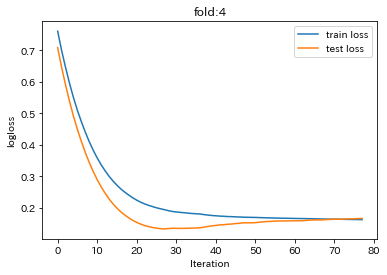

[I 2021-12-27 17:25:01,270] A new study created in memory with name: no-name-aac1ebff-1080-481a-af10-f9a1403830c0
[I 2021-12-27 17:25:01,452] Trial 0 finished with value: 0.13702868090971917 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.13702868090971917.


[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	Train's rmse: 0.139606	Test's rmse: 0.137029
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	Train's rmse: 0.135501	Test's rmse: 0.141689


[I 2021-12-27 17:25:01,669] Trial 1 finished with value: 0.14168889663549553 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.13702868090971917.


[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:25:01,872] Trial 2 finished with value: 0.14090887977448535 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.13702868090971917.


Early stopping, best iteration is:
[41]	Train's rmse: 0.133008	Test's rmse: 0.140909
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	Train's rmse: 0.135306	Test's rmse: 0.136982


[I 2021-12-27 17:25:02,053] Trial 3 finished with value: 0.1369822849378006 and parameters: {'feature_fraction': 0.5}. Best is trial 3 with value: 0.1369822849378006.
[I 2021-12-27 17:25:02,245] Trial 4 finished with value: 0.1418057386045285 and parameters: {'feature_fraction': 0.7}. Best is trial 3 with value: 0.1369822849378006.


[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	Train's rmse: 0.133635	Test's rmse: 0.141806


[I 2021-12-27 17:25:02,406] Trial 5 finished with value: 0.14128687512186724 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 3 with value: 0.1369822849378006.


[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	Train's rmse: 0.133828	Test's rmse: 0.141287
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:25:02,568] Trial 6 finished with value: 0.14129913427721055 and parameters: {'feature_fraction': 0.8}. Best is trial 3 with value: 0.1369822849378006.


Early stopping, best iteration is:
[39]	Train's rmse: 0.133753	Test's rmse: 0.141299
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:25:02,883] Trial 7 finished with value: 0.13690270127279724 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.13690270127279724.


Early stopping, best iteration is:
[43]	Train's rmse: 0.13356	Test's rmse: 0.136903
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:25:03,578] Trial 8 finished with value: 0.1369021505970405 and parameters: {'num_leaves': 244}. Best is trial 8 with value: 0.1369021505970405.


Early stopping, best iteration is:
[43]	Train's rmse: 0.133559	Test's rmse: 0.136902
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:25:04,115] Trial 9 finished with value: 0.13690223235725674 and parameters: {'num_leaves': 188}. Best is trial 8 with value: 0.1369021505970405.


Early stopping, best iteration is:
[43]	Train's rmse: 0.133559	Test's rmse: 0.136902
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:25:04,599] Trial 10 finished with value: 0.13690193561561476 and parameters: {'num_leaves': 154}. Best is trial 10 with value: 0.13690193561561476.


Early stopping, best iteration is:
[43]	Train's rmse: 0.133559	Test's rmse: 0.136902
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	Train's rmse: 0.133566	Test's rmse: 0.136886


[I 2021-12-27 17:25:04,786] Trial 11 finished with value: 0.13688627745414325 and parameters: {'num_leaves': 41}. Best is trial 11 with value: 0.13688627745414325.
[I 2021-12-27 17:25:04,952] Trial 12 finished with value: 0.13688627745414325 and parameters: {'num_leaves': 41}. Best is trial 11 with value: 0.13688627745414325.


[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	Train's rmse: 0.133566	Test's rmse: 0.136886
[LightGBM] [Info] Total Bins 2052


[I 2021-12-27 17:25:05,084] Trial 13 finished with value: 0.1364046429036395 and parameters: {'num_leaves': 16}. Best is trial 13 with value: 0.1364046429036395.


[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	Train's rmse: 0.135453	Test's rmse: 0.136405
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:25:05,909] Trial 14 finished with value: 0.13690187775586046 and parameters: {'num_leaves': 222}. Best is trial 13 with value: 0.1364046429036395.


Early stopping, best iteration is:
[43]	Train's rmse: 0.133559	Test's rmse: 0.136902
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:25:06,510] Trial 15 finished with value: 0.1369023725675085 and parameters: {'num_leaves': 155}. Best is trial 13 with value: 0.1364046429036395.


Early stopping, best iteration is:
[43]	Train's rmse: 0.133559	Test's rmse: 0.136902
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:25:07,078] Trial 16 finished with value: 0.13690242652070098 and parameters: {'num_leaves': 182}. Best is trial 13 with value: 0.1364046429036395.
[I 2021-12-27 17:25:07,162] Trial 17 finished with value: 0.13747829126801692 and parameters: {'num_leaves': 7}. Best is trial 13 with value: 0.1364046429036395.


Early stopping, best iteration is:
[43]	Train's rmse: 0.133559	Test's rmse: 0.136902
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	Train's rmse: 0.133032	Test's rmse: 0.137478
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:25:07,447] Trial 18 finished with value: 0.1368549068360321 and parameters: {'num_leaves': 76}. Best is trial 13 with value: 0.1364046429036395.


Early stopping, best iteration is:
[43]	Train's rmse: 0.133555	Test's rmse: 0.136855
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:25:07,795] Trial 19 finished with value: 0.13690289934946812 and parameters: {'num_leaves': 95}. Best is trial 13 with value: 0.1364046429036395.


Early stopping, best iteration is:
[43]	Train's rmse: 0.13356	Test's rmse: 0.136903
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:25:08,145] Trial 20 finished with value: 0.13685335241337193 and parameters: {'num_leaves': 74}. Best is trial 13 with value: 0.1364046429036395.
[I 2021-12-27 17:25:08,242] Trial 21 finished with value: 0.14168825276506658 and parameters: {'num_leaves': 4}. Best is trial 13 with value: 0.1364046429036395.


Early stopping, best iteration is:
[43]	Train's rmse: 0.133551	Test's rmse: 0.136853
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130565	Test's rmse: 0.141688
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:25:08,531] Trial 22 finished with value: 0.1368628961374428 and parameters: {'num_leaves': 52}. Best is trial 13 with value: 0.1364046429036395.


Early stopping, best iteration is:
[43]	Train's rmse: 0.133547	Test's rmse: 0.136863
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:25:09,025] Trial 23 finished with value: 0.13690199941225878 and parameters: {'num_leaves': 121}. Best is trial 13 with value: 0.1364046429036395.


Early stopping, best iteration is:
[43]	Train's rmse: 0.13356	Test's rmse: 0.136902
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:25:09,325] Trial 24 finished with value: 0.13615696082492762 and parameters: {'num_leaves': 68}. Best is trial 24 with value: 0.13615696082492762.


Early stopping, best iteration is:
[35]	Train's rmse: 0.136331	Test's rmse: 0.136157
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	Train's rmse: 0.136284	Test's rmse: 0.13633


[I 2021-12-27 17:25:09,516] Trial 25 finished with value: 0.13632978462217374 and parameters: {'num_leaves': 26}. Best is trial 24 with value: 0.13615696082492762.


[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:25:09,827] Trial 26 finished with value: 0.13688998131732927 and parameters: {'num_leaves': 61}. Best is trial 24 with value: 0.13615696082492762.


Early stopping, best iteration is:
[43]	Train's rmse: 0.133575	Test's rmse: 0.13689
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:25:10,204] Trial 27 finished with value: 0.16319739628246818 and parameters: {'bagging_fraction': 0.624724071308792, 'bagging_freq': 7}. Best is trial 27 with value: 0.16319739628246818.


Early stopping, best iteration is:
[49]	Train's rmse: 0.172765	Test's rmse: 0.163197
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:25:10,557] Trial 28 finished with value: 0.1460081026036883 and parameters: {'bagging_fraction': 0.8391963650875751, 'bagging_freq': 5}. Best is trial 28 with value: 0.1460081026036883.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137908	Test's rmse: 0.146008
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:25:10,869] Trial 29 finished with value: 0.18371593577931497 and parameters: {'bagging_fraction': 0.49361118426561795, 'bagging_freq': 2}. Best is trial 28 with value: 0.1460081026036883.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.183039	Test's rmse: 0.183716
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:25:11,148] Trial 30 finished with value: 0.18835839614958866 and parameters: {'bagging_fraction': 0.4348501673009778, 'bagging_freq': 7}. Best is trial 28 with value: 0.1460081026036883.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.188917	Test's rmse: 0.188358
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:25:11,452] Trial 31 finished with value: 0.15305633297384413 and parameters: {'bagging_fraction': 0.7606690070465265, 'bagging_freq': 5}. Best is trial 28 with value: 0.1460081026036883.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.150313	Test's rmse: 0.153056
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:25:11,848] Trial 32 finished with value: 0.19624640495698695 and parameters: {'bagging_fraction': 0.41235069657750206, 'bagging_freq': 7}. Best is trial 28 with value: 0.1460081026036883.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.193566	Test's rmse: 0.196246
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:25:12,243] Trial 33 finished with value: 0.14046251715939345 and parameters: {'bagging_fraction': 0.8994655844810855, 'bagging_freq': 2}. Best is trial 33 with value: 0.14046251715939345.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133062	Test's rmse: 0.140463
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:25:12,679] Trial 34 finished with value: 0.17825762317409977 and parameters: {'bagging_fraction': 0.5090949803244422, 'bagging_freq': 2}. Best is trial 33 with value: 0.14046251715939345.


Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.179855	Test's rmse: 0.178258
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:25:13,101] Trial 35 finished with value: 0.16994007467980277 and parameters: {'bagging_fraction': 0.5825453457760269, 'bagging_freq': 4}. Best is trial 33 with value: 0.14046251715939345.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.174508	Test's rmse: 0.16994
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:25:13,526] Trial 36 finished with value: 0.16176840294964068 and parameters: {'bagging_fraction': 0.6591670111857015, 'bagging_freq': 3}. Best is trial 33 with value: 0.14046251715939345.


Early stopping, best iteration is:
[48]	Train's rmse: 0.169617	Test's rmse: 0.161768
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:25:13,860] Trial 37 finished with value: 0.13615696082492762 and parameters: {'feature_fraction': 0.5479999999999999}. Best is trial 37 with value: 0.13615696082492762.


Early stopping, best iteration is:
[35]	Train's rmse: 0.136331	Test's rmse: 0.136157
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:25:14,150] Trial 38 finished with value: 0.13615696082492762 and parameters: {'feature_fraction': 0.45199999999999996}. Best is trial 37 with value: 0.13615696082492762.


Early stopping, best iteration is:
[35]	Train's rmse: 0.136331	Test's rmse: 0.136157
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:25:14,455] Trial 39 finished with value: 0.13615696082492762 and parameters: {'feature_fraction': 0.484}. Best is trial 37 with value: 0.13615696082492762.


Early stopping, best iteration is:
[35]	Train's rmse: 0.136331	Test's rmse: 0.136157
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:25:14,759] Trial 40 finished with value: 0.1416155670162619 and parameters: {'feature_fraction': 0.58}. Best is trial 37 with value: 0.13615696082492762.


Early stopping, best iteration is:
[35]	Train's rmse: 0.135593	Test's rmse: 0.141616
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:25:15,058] Trial 41 finished with value: 0.13615696082492762 and parameters: {'feature_fraction': 0.516}. Best is trial 37 with value: 0.13615696082492762.


Early stopping, best iteration is:
[35]	Train's rmse: 0.136331	Test's rmse: 0.136157
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:25:15,386] Trial 42 finished with value: 0.1377912808399386 and parameters: {'feature_fraction': 0.42}. Best is trial 37 with value: 0.13615696082492762.


Early stopping, best iteration is:
[40]	Train's rmse: 0.13959	Test's rmse: 0.137791
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 17:25:15,734] Trial 43 finished with value: 0.14212151788212585 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403}. Best is trial 43 with value: 0.14212151788212585.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128625	Test's rmse: 0.142122
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2021-12-27 17:25:16,001] Trial 44 finished with value: 0.13639494895436394 and parameters: {'lambda_l1': 0.038720902953704193, 'lambda_l2': 0.0024430162614261413}. Best is trial 44 with value: 0.13639494895436394.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 17:25:16,309] Trial 45 finished with value: 0.1361569613484167 and parameters: {'lambda_l1': 2.5361081166471375e-07, 'lambda_l2': 2.5348407664333426e-07}. Best is trial 45 with value: 0.1361569613484167.


Early stopping, best iteration is:
[35]	Train's rmse: 0.136331	Test's rmse: 0.136157
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2021-12-27 17:25:16,623] Trial 46 finished with value: 0.13574166065302679 and parameters: {'lambda_l1': 3.3323645788192616e-08, 'lambda_l2': 0.6245760287469893}. Best is trial 46 with value: 0.13574166065302679.


Early stopping, best iteration is:
[37]	Train's rmse: 0.135717	Test's rmse: 0.135742
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 17:25:16,985] Trial 47 finished with value: 0.13704998798739917 and parameters: {'lambda_l1': 0.002570603566117598, 'lambda_l2': 0.023585940584142682}. Best is trial 46 with value: 0.13574166065302679.


Early stopping, best iteration is:
[37]	Train's rmse: 0.135272	Test's rmse: 0.13705
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 17:25:17,329] Trial 48 finished with value: 0.13830991265246237 and parameters: {'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285}. Best is trial 46 with value: 0.13574166065302679.


Early stopping, best iteration is:
[48]	Train's rmse: 0.135049	Test's rmse: 0.13831
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 17:25:17,533] Trial 49 finished with value: 0.13605812526629874 and parameters: {'lambda_l1': 0.31044435499483225, 'lambda_l2': 8.148018307012941e-07}. Best is trial 46 with value: 0.13574166065302679.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[42]	Train's rmse: 0.134329	Test's rmse: 0.136058
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set

[I 2021-12-27 17:25:17,893] Trial 50 finished with value: 0.13615696162487362 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07}. Best is trial 46 with value: 0.13574166065302679.


Early stopping, best iteration is:
[35]	Train's rmse: 0.136331	Test's rmse: 0.136157
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:25:18,230] Trial 51 finished with value: 0.1361509672230601 and parameters: {'lambda_l1': 5.472429642032198e-06, 'lambda_l2': 0.00052821153945323}. Best is trial 46 with value: 0.13574166065302679.


Early stopping, best iteration is:
[35]	Train's rmse: 0.136328	Test's rmse: 0.136151
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:25:18,555] Trial 52 finished with value: 0.13615186606513657 and parameters: {'lambda_l1': 7.71800699380605e-05, 'lambda_l2': 4.17890272377219e-06}. Best is trial 46 with value: 0.13574166065302679.
[I 2021-12-27 17:25:18,696] Trial 53 finished with value: 0.1389865665726509 and parameters: {'lambda_l1': 3.207959657544482, 'lambda_l2': 0.09866694315446872}. Best is trial 46 with value: 0.13574166065302679.


Early stopping, best iteration is:
[35]	Train's rmse: 0.136326	Test's rmse: 0.136152
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2021-12-27 17:25:18,841] Trial 54 finished with value: 0.13565274262501859 and parameters: {'lambda_l1': 5.319049072944658, 'lambda_l2': 1.2787005110682527e-08}. Best is trial 54 with value: 0.13565274262501859.


[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[I 2021-12-27 17:25:19,215] Trial 55 finished with value: 0.1369005302190235 and parameters: {'lambda_l1': 0.0012317365144257704, 'lambda_l2': 2.4601392268433573e-05}. Best is trial 54 with value: 0.13565274262501859.
[I 2021-12-27 17:25:19,351] Trial 56 finished with value: 0.13468876659249662 and parameters: {'lambda_l1': 6.301664315323464, 'lambda_l2': 2.3609661928600035e-08}. Best is trial 56 with value: 0.13468876659249662.


Early stopping, best iteration is:
[43]	Train's rmse: 0.133553	Test's rmse: 0.136901
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2021-12-27 17:25:19,509] Trial 57 finished with value: 0.13561626130004872 and parameters: {'lambda_l1': 5.394324270500968, 'lambda_l2': 1.1508453742729904e-08}. Best is trial 56 with value: 0.13468876659249662.



[LightGBM] [Info] Start training from score 0.367256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2021-12-27 17:25:19,761] Trial 58 finished with value: 0.13629025008881587 and parameters: {'lambda_l1': 0.08295974858212225, 'lambda_l2': 1.1971632417248401e-08}. Best is trial 56 with value: 0.13468876659249662.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 17:25:19,947] Trial 59 finished with value: 0.13555325938144436 and parameters: {'lambda_l1': 0.7053870696669258, 'lambda_l2': 3.3622740195700364e-05}. Best is trial 56 with value: 0.13468876659249662.


[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

[I 2021-12-27 17:25:20,143] Trial 60 finished with value: 0.13609935024256548 and parameters: {'lambda_l1': 0.3677392371957708, 'lambda_l2': 0.0001276186791717384}. Best is trial 56 with value: 0.13468876659249662.


[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[I 2021-12-27 17:25:20,466] Trial 61 finished with value: 0.13687024150744603 and parameters: {'lambda_l1': 0.01618131491851606, 'lambda_l2': 3.1383794218951396e-05}. Best is trial 56 with value: 0.13468876659249662.
[I 2021-12-27 17:25:20,635] Trial 62 finished with value: 0.135998174038559 and parameters: {'lambda_l1': 0.4989805060231759, 'lambda_l2': 0.00371789416077685}. Best is trial 56 with value: 0.13468876659249662.


Early stopping, best iteration is:
[43]	Train's rmse: 0.133616	Test's rmse: 0.13687
[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 17:25:20,767] Trial 63 finished with value: 0.1511112865353092 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.1511112865353092.


[LightGBM] [Info] Total Bins 2052
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 10
[LightGBM] [Info] Start training from score 0.367256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

[I 2021-12-27 17:25:20,901] Trial 64 finished with value: 0.27794045313542565 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.1511112865353092.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 17:25:21,045] Trial 65 finished with value: 0.054285382463710695 and parameters: {'min_child_samples': 5}. Best is trial 65 with value: 0.054285382463710695.
[I 2021-12-27 17:25:21,167] Trial 66 finished with value: 0.0889526961254233 and parameters: {'min_child_samples': 10}. Best is trial 65 with value: 0.054285382463710695.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 17:25:21,304] Trial 67 finished with value: 0.2168226529925481 and parameters: {'min_child_samples': 50}. Best is trial 65 with value: 0.054285382463710695.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

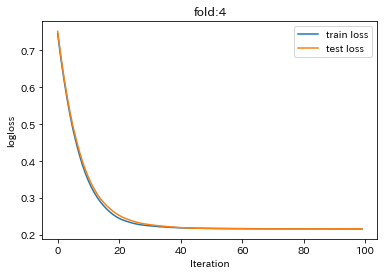

RMSE: [0.08808937204937427, 0.034925279349213384, 0.11912273723721853, 0.06020516919330507, 0.054285376111065646]
RMSE: 0.07132558678803538


In [17]:
# 学習・推論
gkf = GroupKFold(n_splits=5)

params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': 'rmse',             # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'deterministic':True,         # 再現性確保用のパラメータ
          'force_row_wise':True,        # 再現性確保用のパラメータ
          'seed': SEED                  # シード値
          }

groups = pred_df[best_model_name]

cv_result_stck_lgbm = []

for train_index, test_index in gkf.split(pred_df, y_train_dropna, groups):

    X_train_gkf, X_test_gkf = pred_df.iloc[train_index], pred_df.iloc[test_index]
    y_train_gkf, y_test_gkf = y_train_dropna.iloc[train_index], y_train_dropna.iloc[test_index]

    # 学習、推論
    lgb_train = opt_lgb.Dataset(X_train_gkf, y_train_gkf)
    lgb_test = opt_lgb.Dataset(X_test_gkf, y_test_gkf, reference=lgb_train)

    model = opt_lgb.LightGBMTuner(
                    params,                    # ハイパーパラメータをセット
                    lgb_train,              # 訓練データを訓練用にセット
                    valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                    valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                    num_boost_round=100,              # 計算回数
                    early_stopping_rounds=50,         # アーリーストッピング設定
                    evals_result=lgb_results,
                    verbose_eval=-1,                  # ログを最後の1つだけ表示
                    show_progress_bar = False,        # ログの非表示
                    optuna_seed=SEED,
                    )
    
    # 訓練の実施
    model.run()
    
    best_params = model.best_params
    

   # 損失推移を表示
    loss_train = lgb_results['Train']['rmse']
    loss_test = lgb_results['Test']['rmse']   
    
    fig = plt.figure()
    
    plt.xlabel('Iteration')
    plt.ylabel('logloss')

    plt.title(f"fold:{fold}")
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='test loss')
    
    plt.legend()
    plt.show()

    # 推論
    best_model = model.get_best_booster()

    y_pred = best_model.predict(X_test_gkf)

    # 評価
    rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)
    cv_result_stck_lgbm.append(rmse)

print("RMSE:", cv_result_stck_lgbm)
print("RMSE:", np.mean(cv_result_stck_lgbm))

In [18]:
print("RMSE:", round(np.mean(cv_result), 4))
print(f"Best Model {best_model_name} Stacking RMSE:", round(np.mean(cv_result_stck_best_model), 4))
print("Optuna LightGBM Stacking RMSE:", round(np.mean(cv_result_stck_lgbm), 4))

RMSE: 0.1755
Best Model gradient Stacking RMSE: 0.0605
Optuna LightGBM Stacking RMSE: 0.0713
